v0.1 (04/11/24)

## NeuroMotor Project

In [1]:
import pandas as pd
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from tqdm.notebook import trange, tqdm

import scipy.signal as sig

path_all = '../RepositoryData'
# plt.style.use('seaborn-v0_8-bright')


In [2]:
single_subject = path_all + '/SL01-T01'
sgl_subj_eeg = single_subject + '/eeg.txt'

In [3]:
# # check the path
# !ls -l $path_all

In [4]:
# the data we want from 2min to 17min with fs = 100Hz
t_walk_min = [2, 17]
t_first_5=[2,7]
t_first_ten=[2,12]
t_stand_min = [0, 2]
t_walkBCI_min = [17, 22]
t_stand_min_2 = [22, 24]

fs = 100

# Seperates into time periods for walking so that data scarcity can be simulated later
t_walk_data = {'t_start_walk': t_walk_min[0]*60*fs, 't_end_walk': t_walk_min[1]*60*fs}
t_walk_data5 = {'t_start_walk': t_first_5[0]*60*fs, 't_end_walk': t_first_5[1]*60*fs}
t_walk_data10 = {'t_start_walk': t_first_ten[0]*60*fs, 't_end_walk': t_first_ten[1]*60*fs}

# Data that probably wont be used but good to have handel for
t_stand_data = {'t_start_stand': t_stand_min[0]*60*fs, 't_end_stand': t_stand_min[1]*60*fs}
t_walkBCI_data = {'t_start_walkBCI': t_walkBCI_min[0]*60*fs, 't_end_walkBCI': t_walkBCI_min[1]*60*fs}
t_stand_data_2 = {'t_start_stand_2': t_stand_min_2[0]*60*fs, 't_end_stand_2': t_stand_min_2[1]*60*fs}

# all non-BCI data (probably wont be used)
t_useful_data = {'t_start_useful_1': t_stand_data['t_end_stand'], 't_end_useful_1': t_walk_data['t_start_walk'], 't_start_useful_2': t_stand_data_2['t_end_stand_2']}

In [15]:
# Load the data
eeg = pd.read_csv(sgl_subj_eeg, sep='\t', on_bad_lines='warn', skiprows=1, header=None)
eeg.dropna(axis=1, how='all', inplace=True)

# first column is the time in seconds
time = eeg.iloc[:, 0]
eeg = eeg.iloc[:, 1:]

# drops unwanted sections
eeg_walk=eeg.drop(range(t_walk_data['t_start_walk']))
eeg_walk=eeg_walk.drop(range(t_walk_data['t_end_walk']-1, eeg_walk.index[-1]))
eeg_walk = eeg_walk.to_numpy()
perform_drop=len(eeg_walk)==t_walk_data['t_end_walk']- t_walk_data['t_start_walk']

# checks to make sure desired rows were dropped
if perform_drop:
    print('Drop successful')
else:
    print('Length of array is: ' + str(len(eeg_walk)))
    print(' but is supposed to be '+ str(t_walk_data['t_end_walk']- t_walk_data['t_start_walk']))

# For general checking of data:
# eeg = eeg.to_numpy()
# time = time.to_numpy()
# print(eeg.shape, time.shape)

print("Time shape: ", time.shape)
print("EEG shape: ", eeg.shape)
print("EEG walk shape: ", eeg_walk.shape)
print(eeg_walk[:10, 0])

Drop successful
Time shape:  (137242,)
EEG shape:  (137242, 64)
EEG walk shape:  (90000, 64)
[69.8 60.6 64.9 67.7 63.3 65.  61.5 79.1 84.9 97.3]


In [11]:
print("EEG shape: ", eeg.shape)
# Loading dependent variable
sgl_joint_angl=single_subject+'/joints.txt'

# Remove the first 2 lines of the file using skiprows
j_angl = pd.read_csv(sgl_joint_angl, sep='\t', header=None ,names=list(range(14)), skiprows=2)

# processing data
j_angl.dropna(axis=1, how='all', inplace=True)
# first column is the time in seconds
j_time = j_angl.iloc[:, 0]
j_angl = j_angl.drop(0, axis=1)
j_angl = j_angl.drop(range(7,13), axis=1)
print(j_angl.head())

# selects sections we want from joint data
j_walk=j_angl.drop(range(t_walk_data['t_start_walk']))
j_walk=j_walk.drop(range(t_walk_data['t_end_walk']-1, j_walk.index[-1]))
j_walk = j_walk.to_numpy()


print(j_time.shape)
print(j_walk.shape)

joint_labels = ['GHR', 'GKR', 'GAR', 'GHL', 'GKL', 'GAL']
print("EEG shape: ", eeg.shape)

EEG shape:  (137242, 64)
      1      2      3     4      5     6
0  1.44 -6.435 -3.375 -1.26  1.125  3.06
1  1.44 -6.435 -3.375 -1.26  1.125  3.06
2  1.44 -6.435 -3.375 -1.26  1.125  3.06
3  1.44 -6.435 -3.375 -1.26  1.125  3.06
4  1.44 -6.435 -3.375 -1.26  1.125  3.06
(137242,)
(90000, 6)
EEG shape:  (137242, 64)


## Low Pass Filter

In [7]:
def butter_lowpass(cutoff, fs, order=5):
    return sig.butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    print(data.shape[0])
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = sig.lfilter(b, a, data, axis=0)
    return y

def lp(data, fc): # filter out all freq above 50 with 
    return butter_lowpass_filter(data=data, cutoff=fc, fs=100)

(90000, 64)
before eeg shape: (90000, 64)
90000
after eeg shape: (90000, 64)


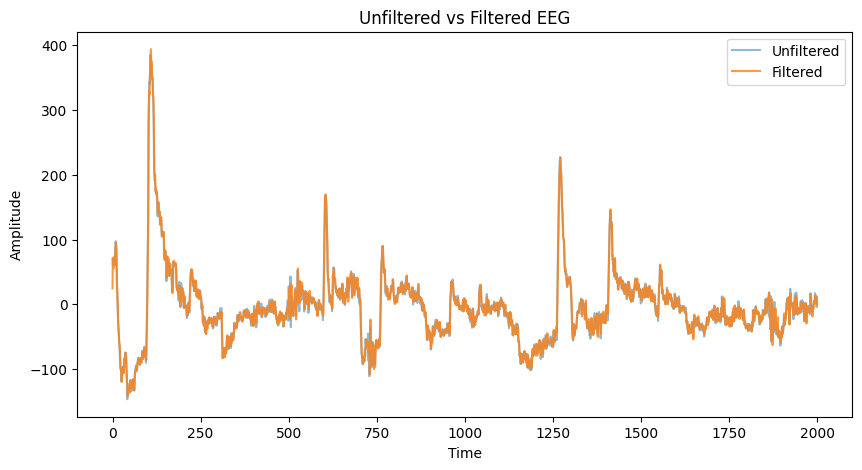

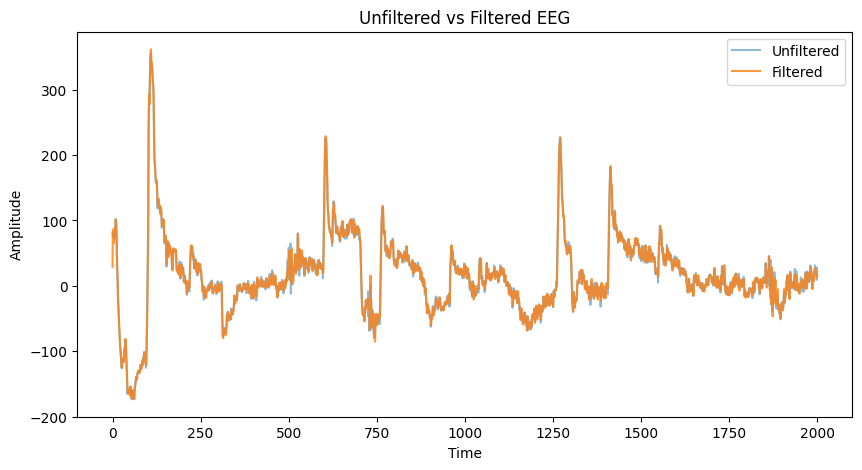

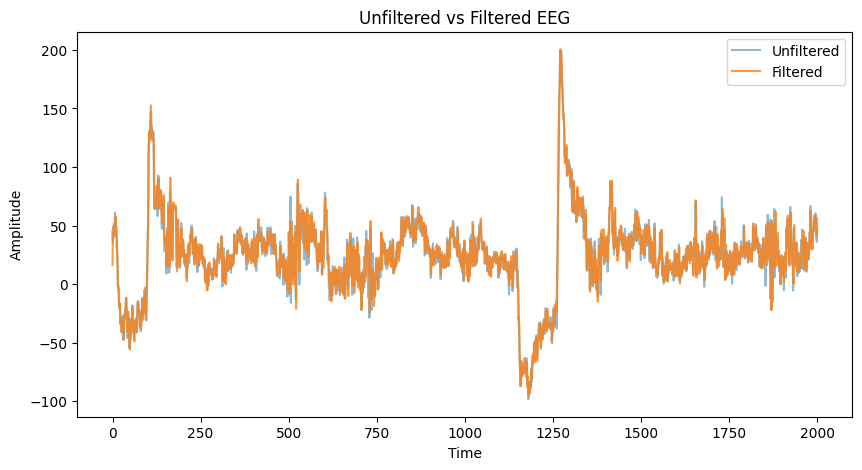

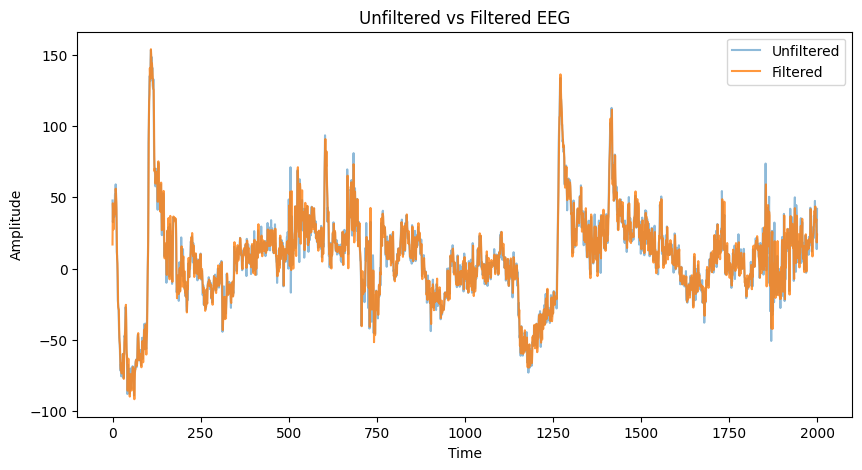

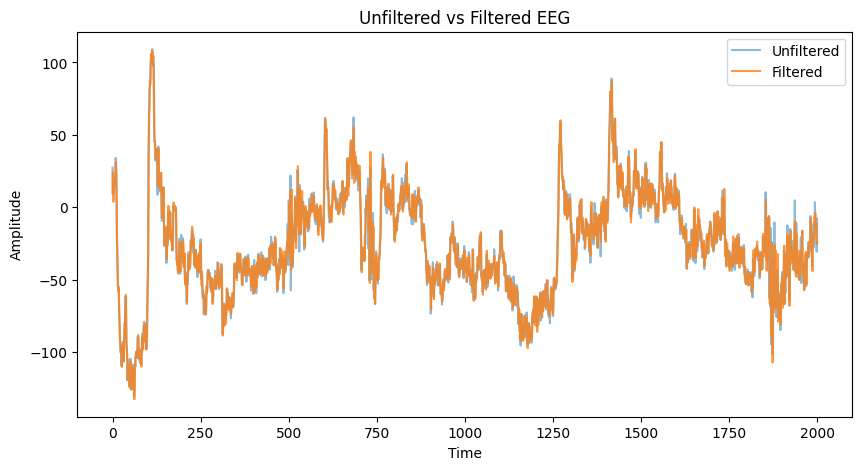

In [12]:
eeg = eeg_walk
print(eeg.shape)

cutoff = 40

eeg_unfiltered = eeg

# apply the low pass filter
print("before eeg shape: " + str(eeg.shape))
eeg = lp(eeg, cutoff)
print("after eeg shape: " + str(eeg.shape))

# plot the unfiletered eeg and the filtered eeg
for i, channel in enumerate(range(eeg.shape[1])):
    if i == 5:
        break

    width = 2000

    plt.figure(figsize=(10, 5))
    plt.plot(eeg_unfiltered[:, channel][0:width], alpha=0.5)
    plt.plot(eeg[:, channel][0:width], alpha=0.8)
    plt.title('Unfiltered vs Filtered EEG')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend(['Unfiltered', 'Filtered'])
    plt.show()




## PCA

  0%|          | 0/25 [00:00<?, ?it/s]

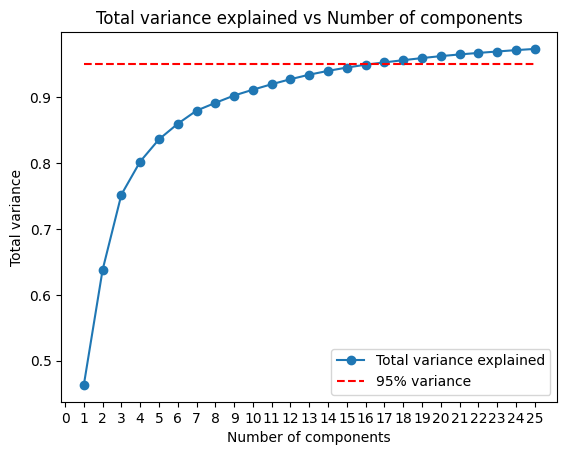

Number of components needed to explain 95% variance:  17


In [18]:
max_num_components = 25

num_components = range(1, max_num_components + 1)
total_variance = []

pca = decomposition.PCA(n_components=max_num_components)
pca.fit(eeg)

for i in tqdm(num_components):
    variance = np.sum(pca.explained_variance_ratio_[:i])
    total_variance.append(variance)

plt.plot(num_components, total_variance, marker='o', label='Total variance explained')
plt.plot(num_components, [.95 for _ in num_components], linestyle='--', color='r', label='95% variance')
plt.xlabel('Number of components')
plt.ylabel('Total variance')
plt.title('Total variance explained vs Number of components')
plt.legend()
plt.xticks(range(0, len(num_components) + 1))
plt.show()

above_95 = [i for i, v in enumerate(total_variance) if v > 0.95]
print("Number of components needed to explain 95% variance: ", num_components[above_95[0]])

In [19]:
def pca_transform(data, n_components):
    pca = decomposition.PCA(n_components=n_components)
    return pca.fit_transform(data)

## ICA

### Donovan's Attempt At ICA

ICA components shape:  (90000, 64)


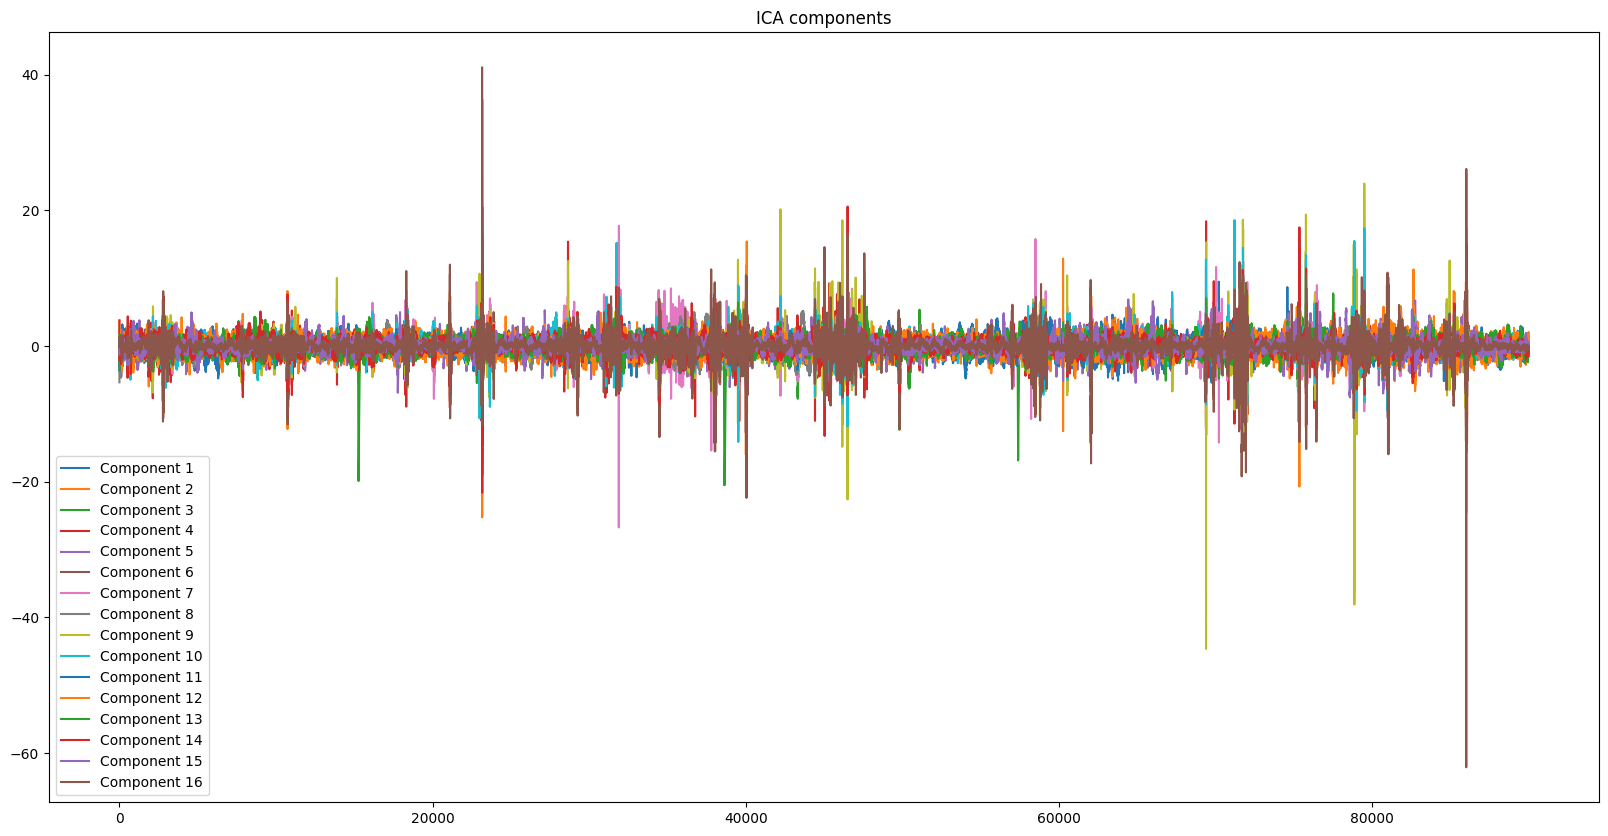

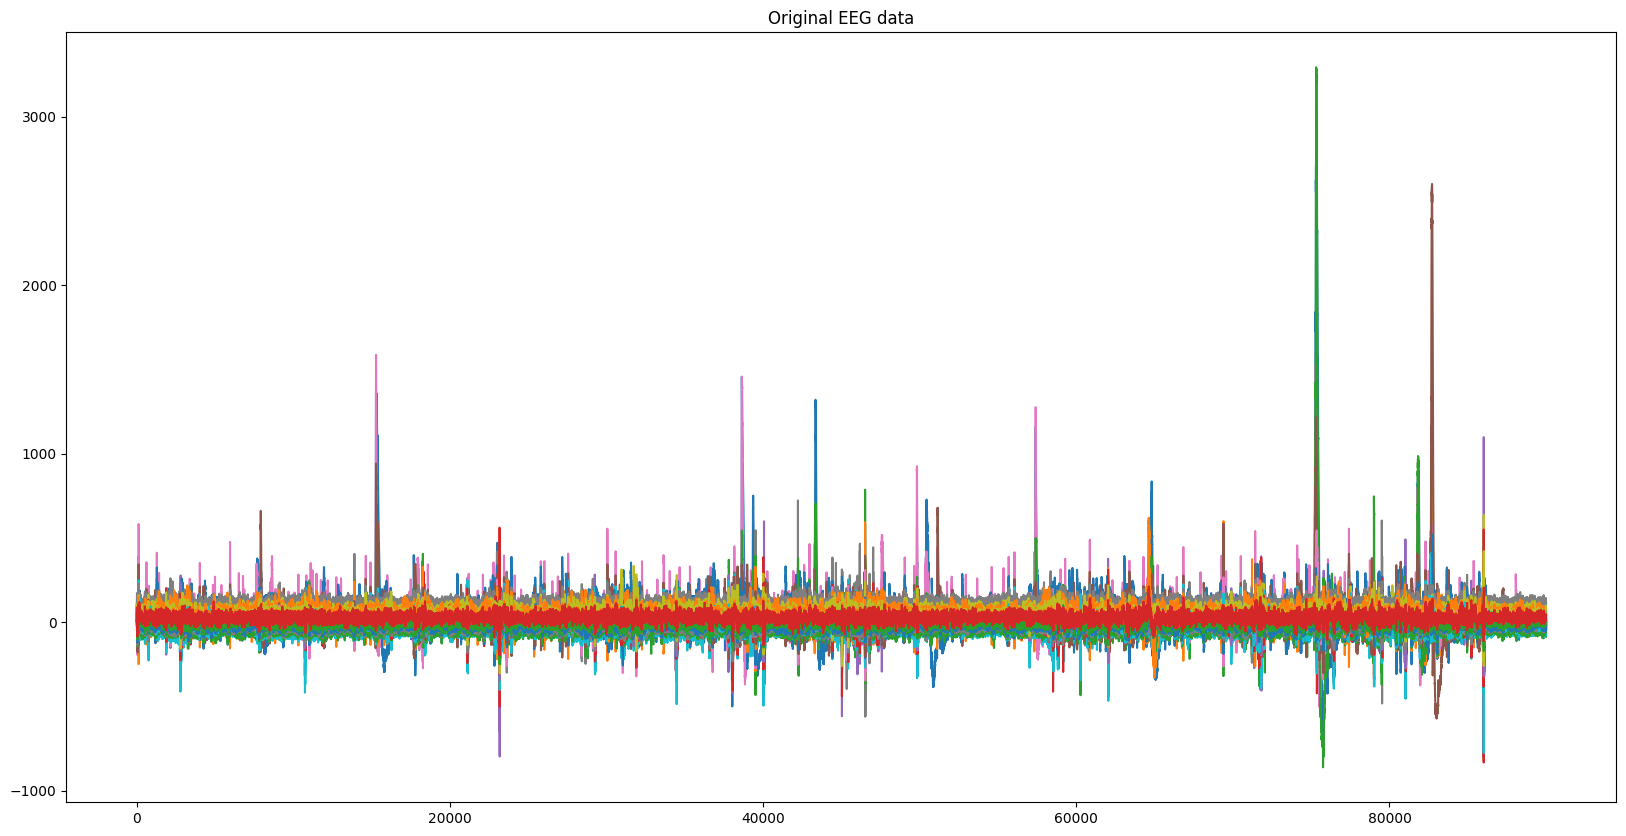

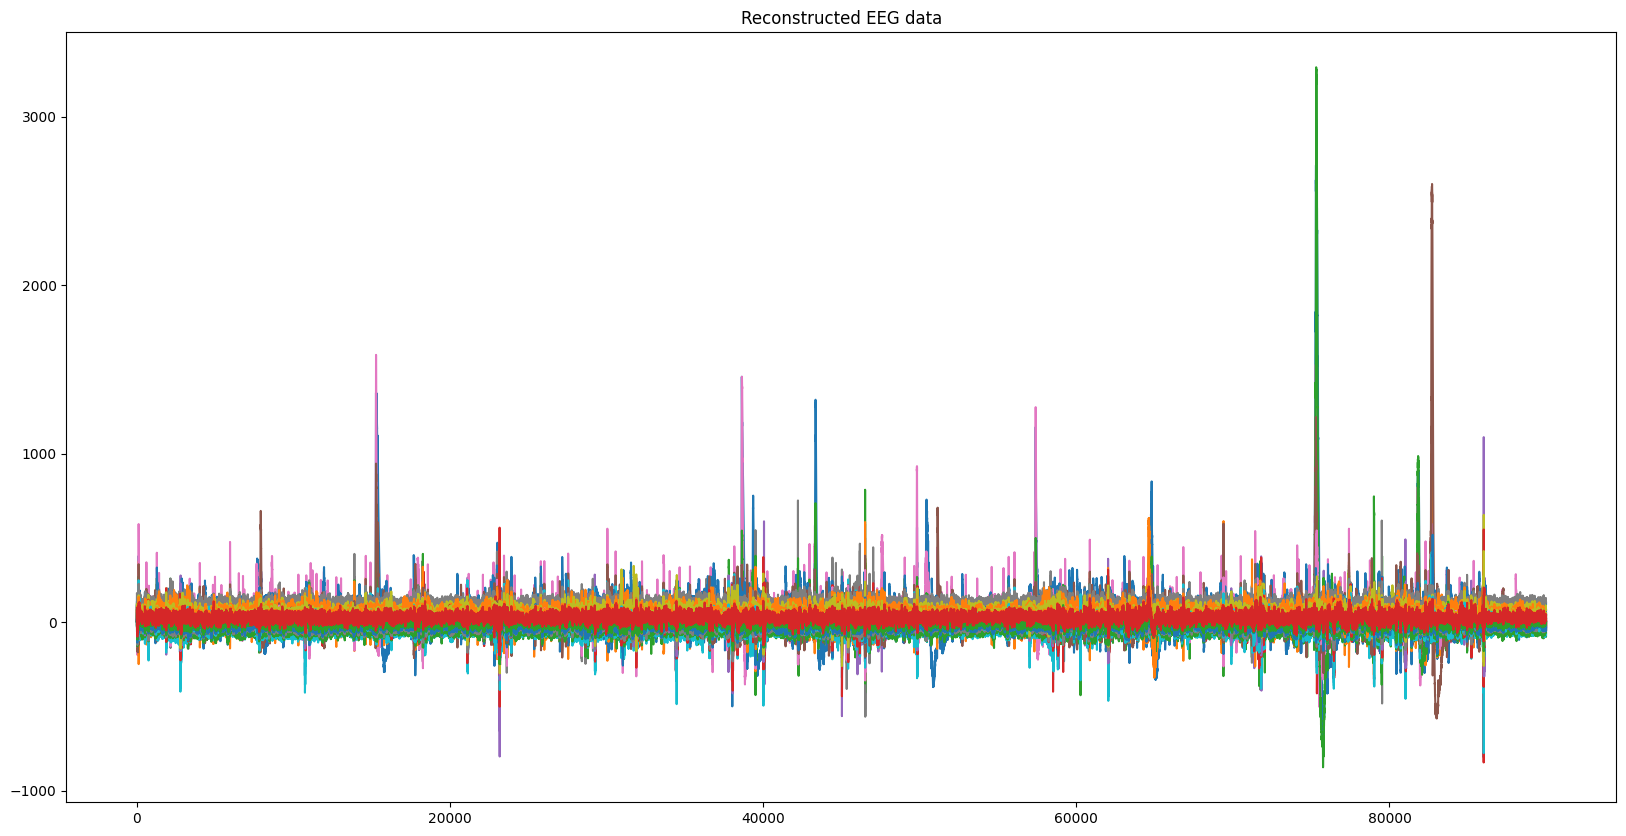

In [20]:
ica = decomposition.FastICA()
eeg_ica = ica.fit_transform(eeg)
# eeg_ica = ica.transform(eeg)

print("ICA components shape: ", eeg_ica.shape)

# Plot the ICA components
plt.figure(figsize=(20, 10))
for i in range(above_95[0]):
    plt.plot(eeg_ica[:, i], label=f'Component {i+1}')
plt.legend()
plt.title('ICA components')
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(eeg)
plt.title('Original EEG data')
plt.show()

# Check if the ICA components can be transformed back to the original data
eeg_reconstructed = ica.inverse_transform(eeg_ica)
plt.figure(figsize=(20, 10))
plt.plot(eeg_reconstructed)
plt.title('Reconstructed EEG data')
plt.show()


In [21]:
print(np.allclose(eeg, eeg_ica))

False


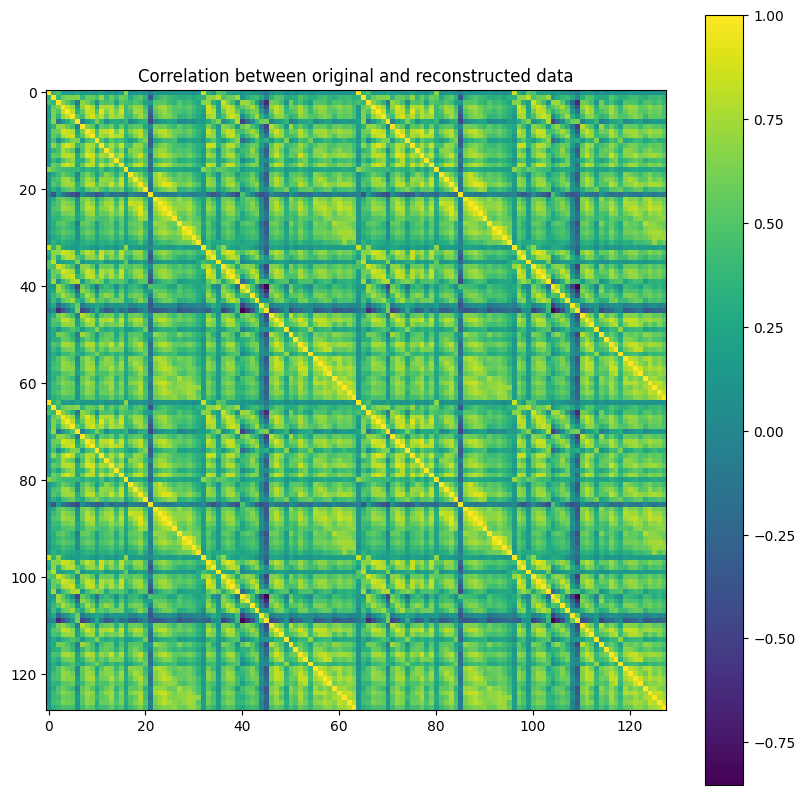

In [22]:

# Check the correlation between the original and reconstructed data
correlation = np.corrcoef(eeg.T, eeg_reconstructed.T)
plt.figure(figsize=(10, 10))
plt.imshow(correlation, cmap='viridis')
plt.colorbar()
plt.title('Correlation between original and reconstructed data')
plt.show()

## FFTs

### Windowing


In [23]:
# use fourier transform to get the signal in frequency domain
def fourier_transform(data, fs):
    n = len(data)

    f = np.fft.fftfreq(n, 1/fs)
    y = np.abs(np.fft.fft(data, axis=0))

    f = np.abs(np.fft.fftshift(f))
    y = np.fft.fftshift(y, axes=0)
    return f, y

Number of windows in the data:  4500
Window shape:  (20, 20)
Joint angle shape:  (20, 6)
Frequency shape:  (20,)
Magnitude shape:  (20, 20)
Frequency range:  0.0 50.0


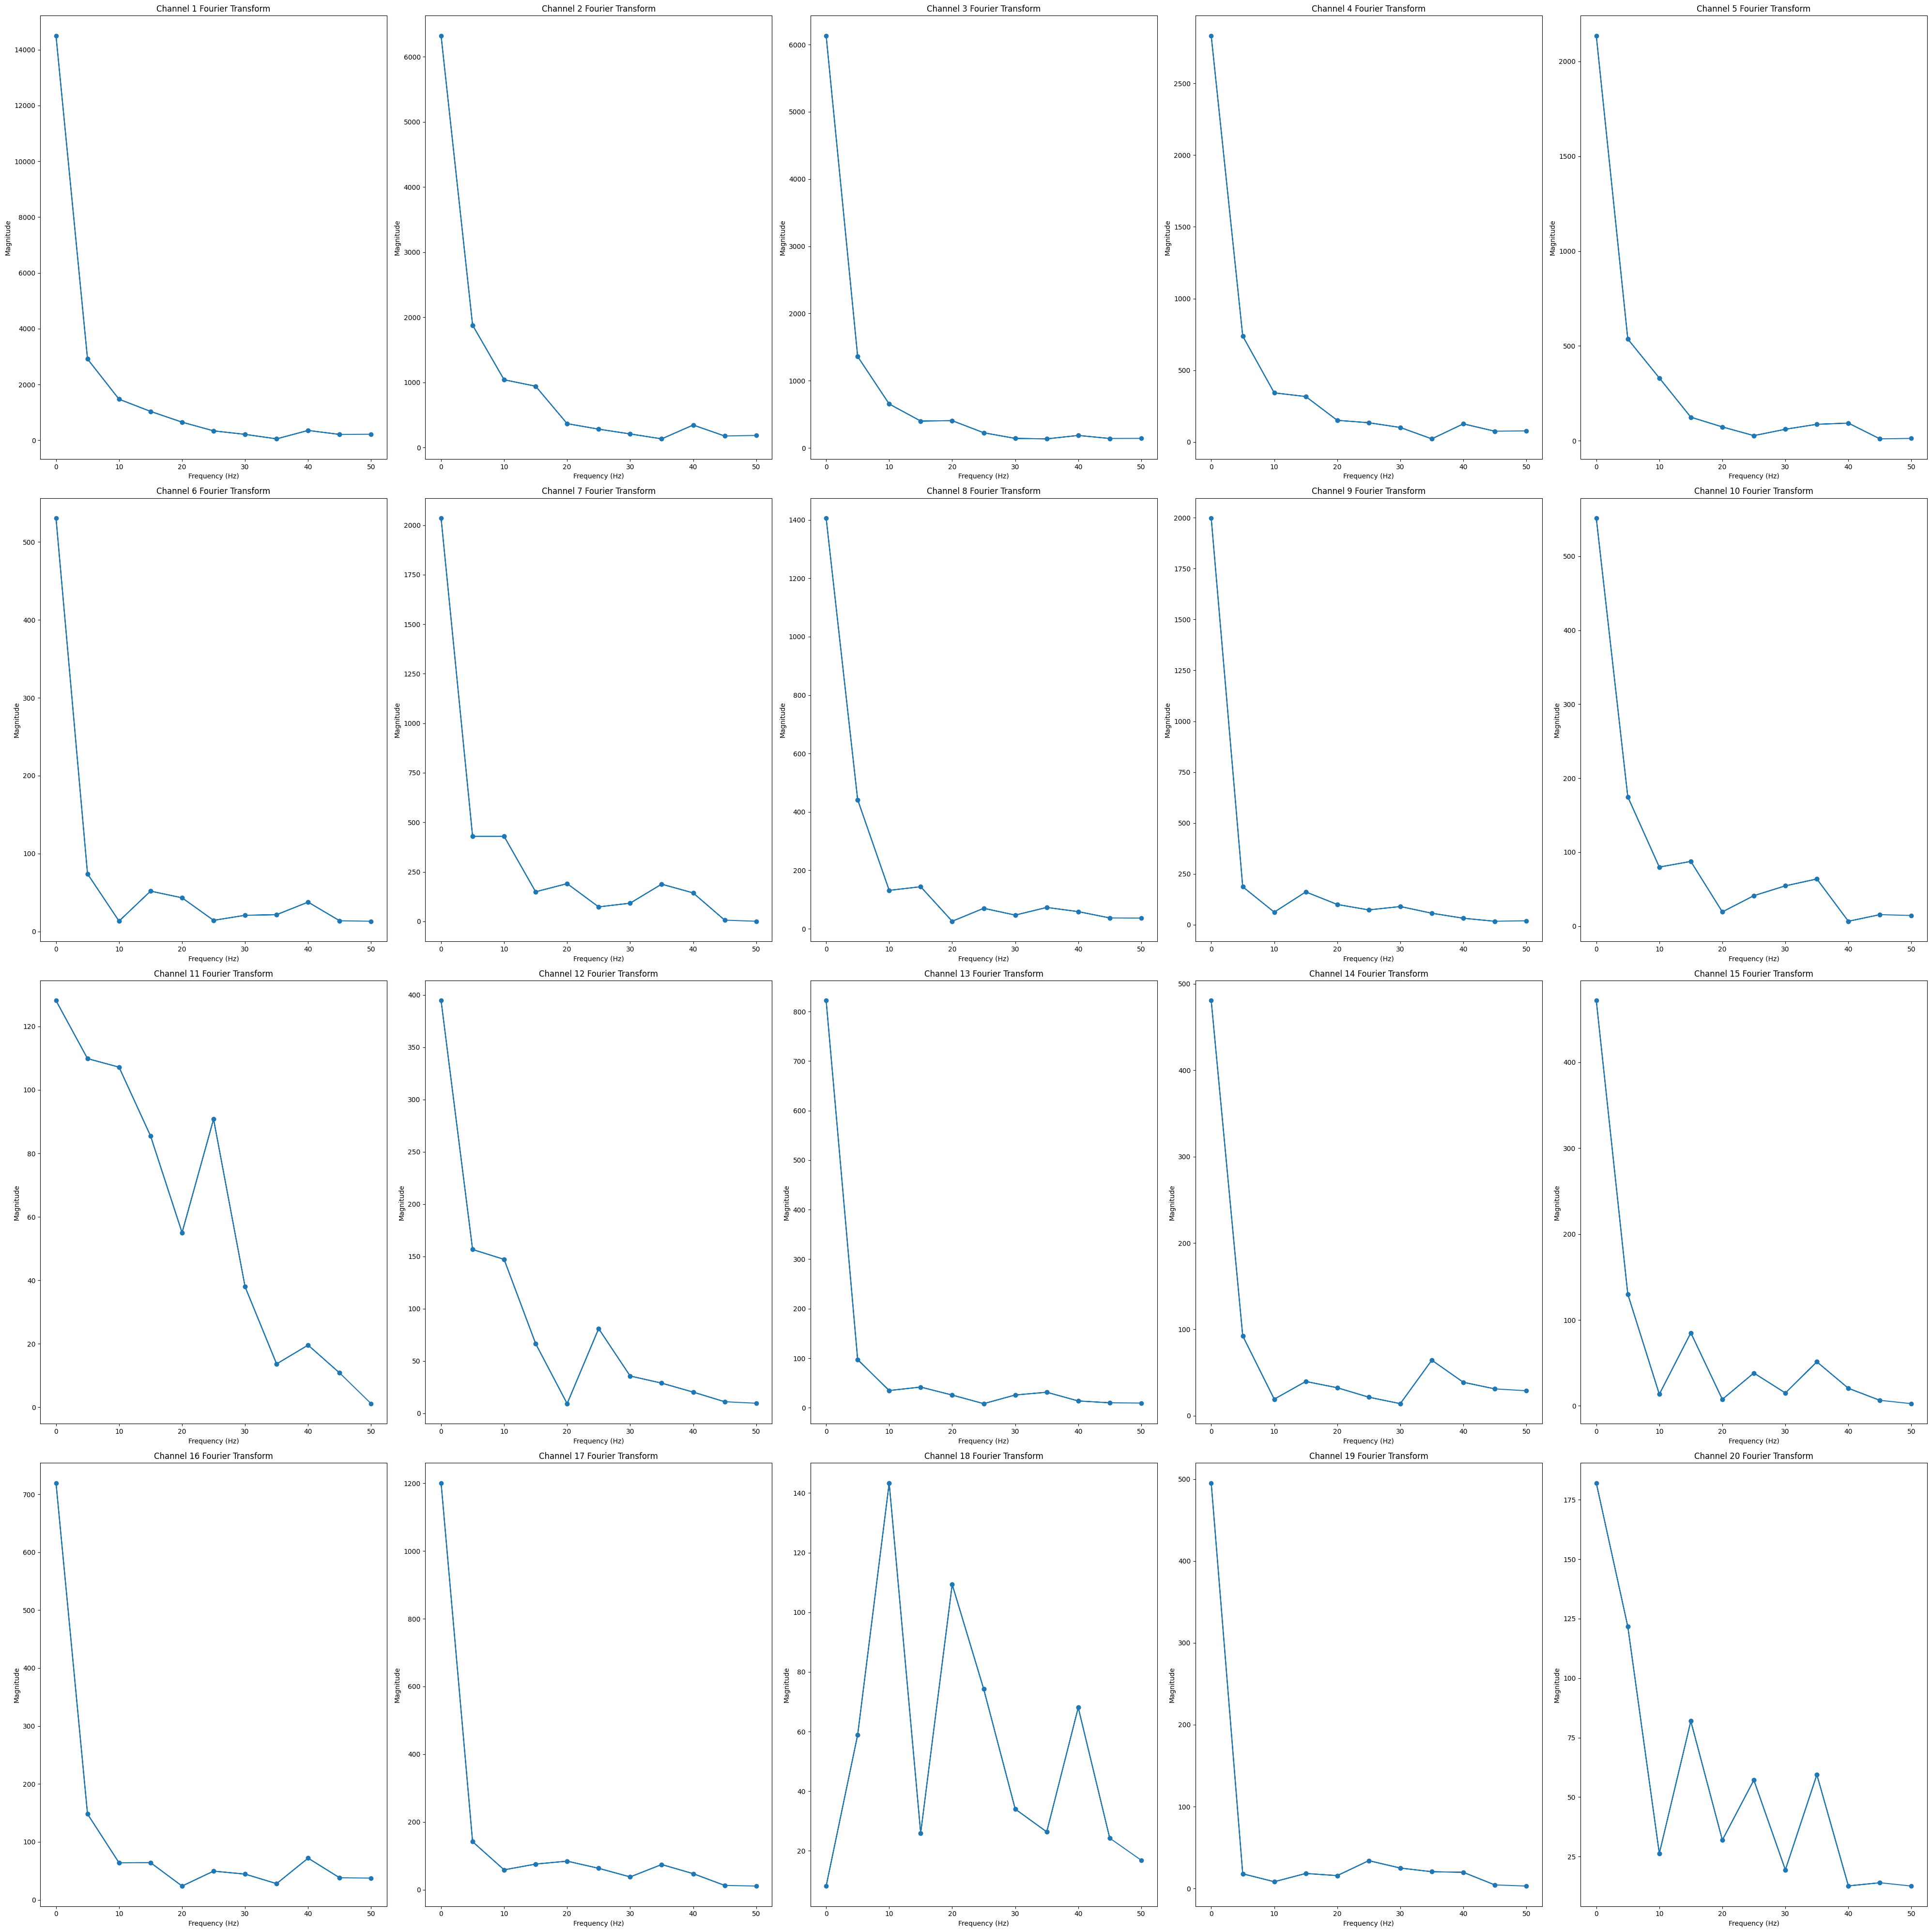

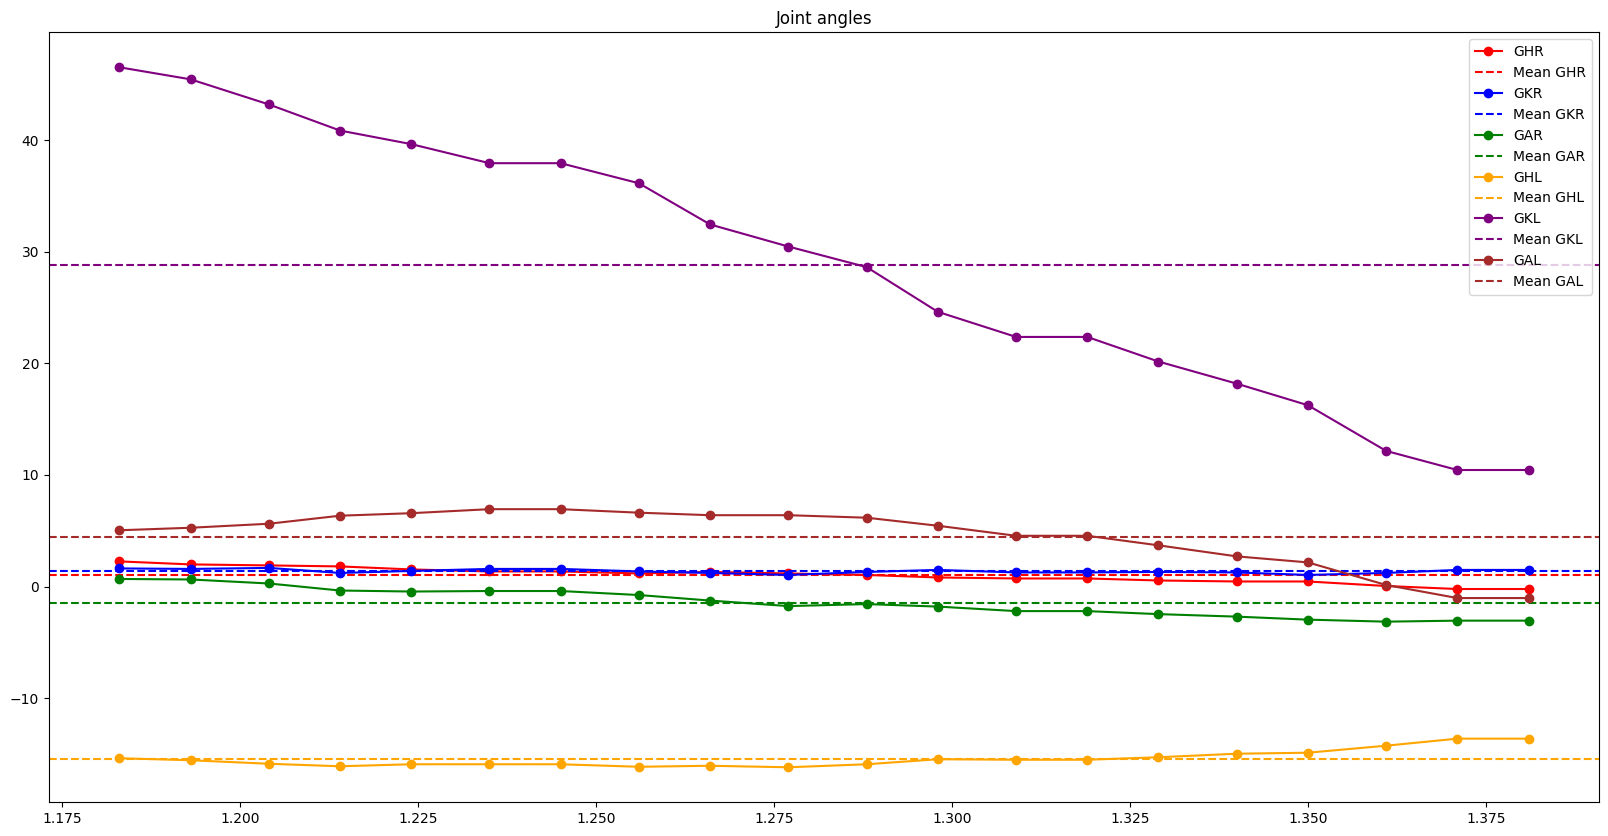

Window shape:  (20, 20)
Joint angle shape:  (20, 6)
Frequency shape:  (20,)
Magnitude shape:  (20, 20)
Frequency range:  0.0 50.0


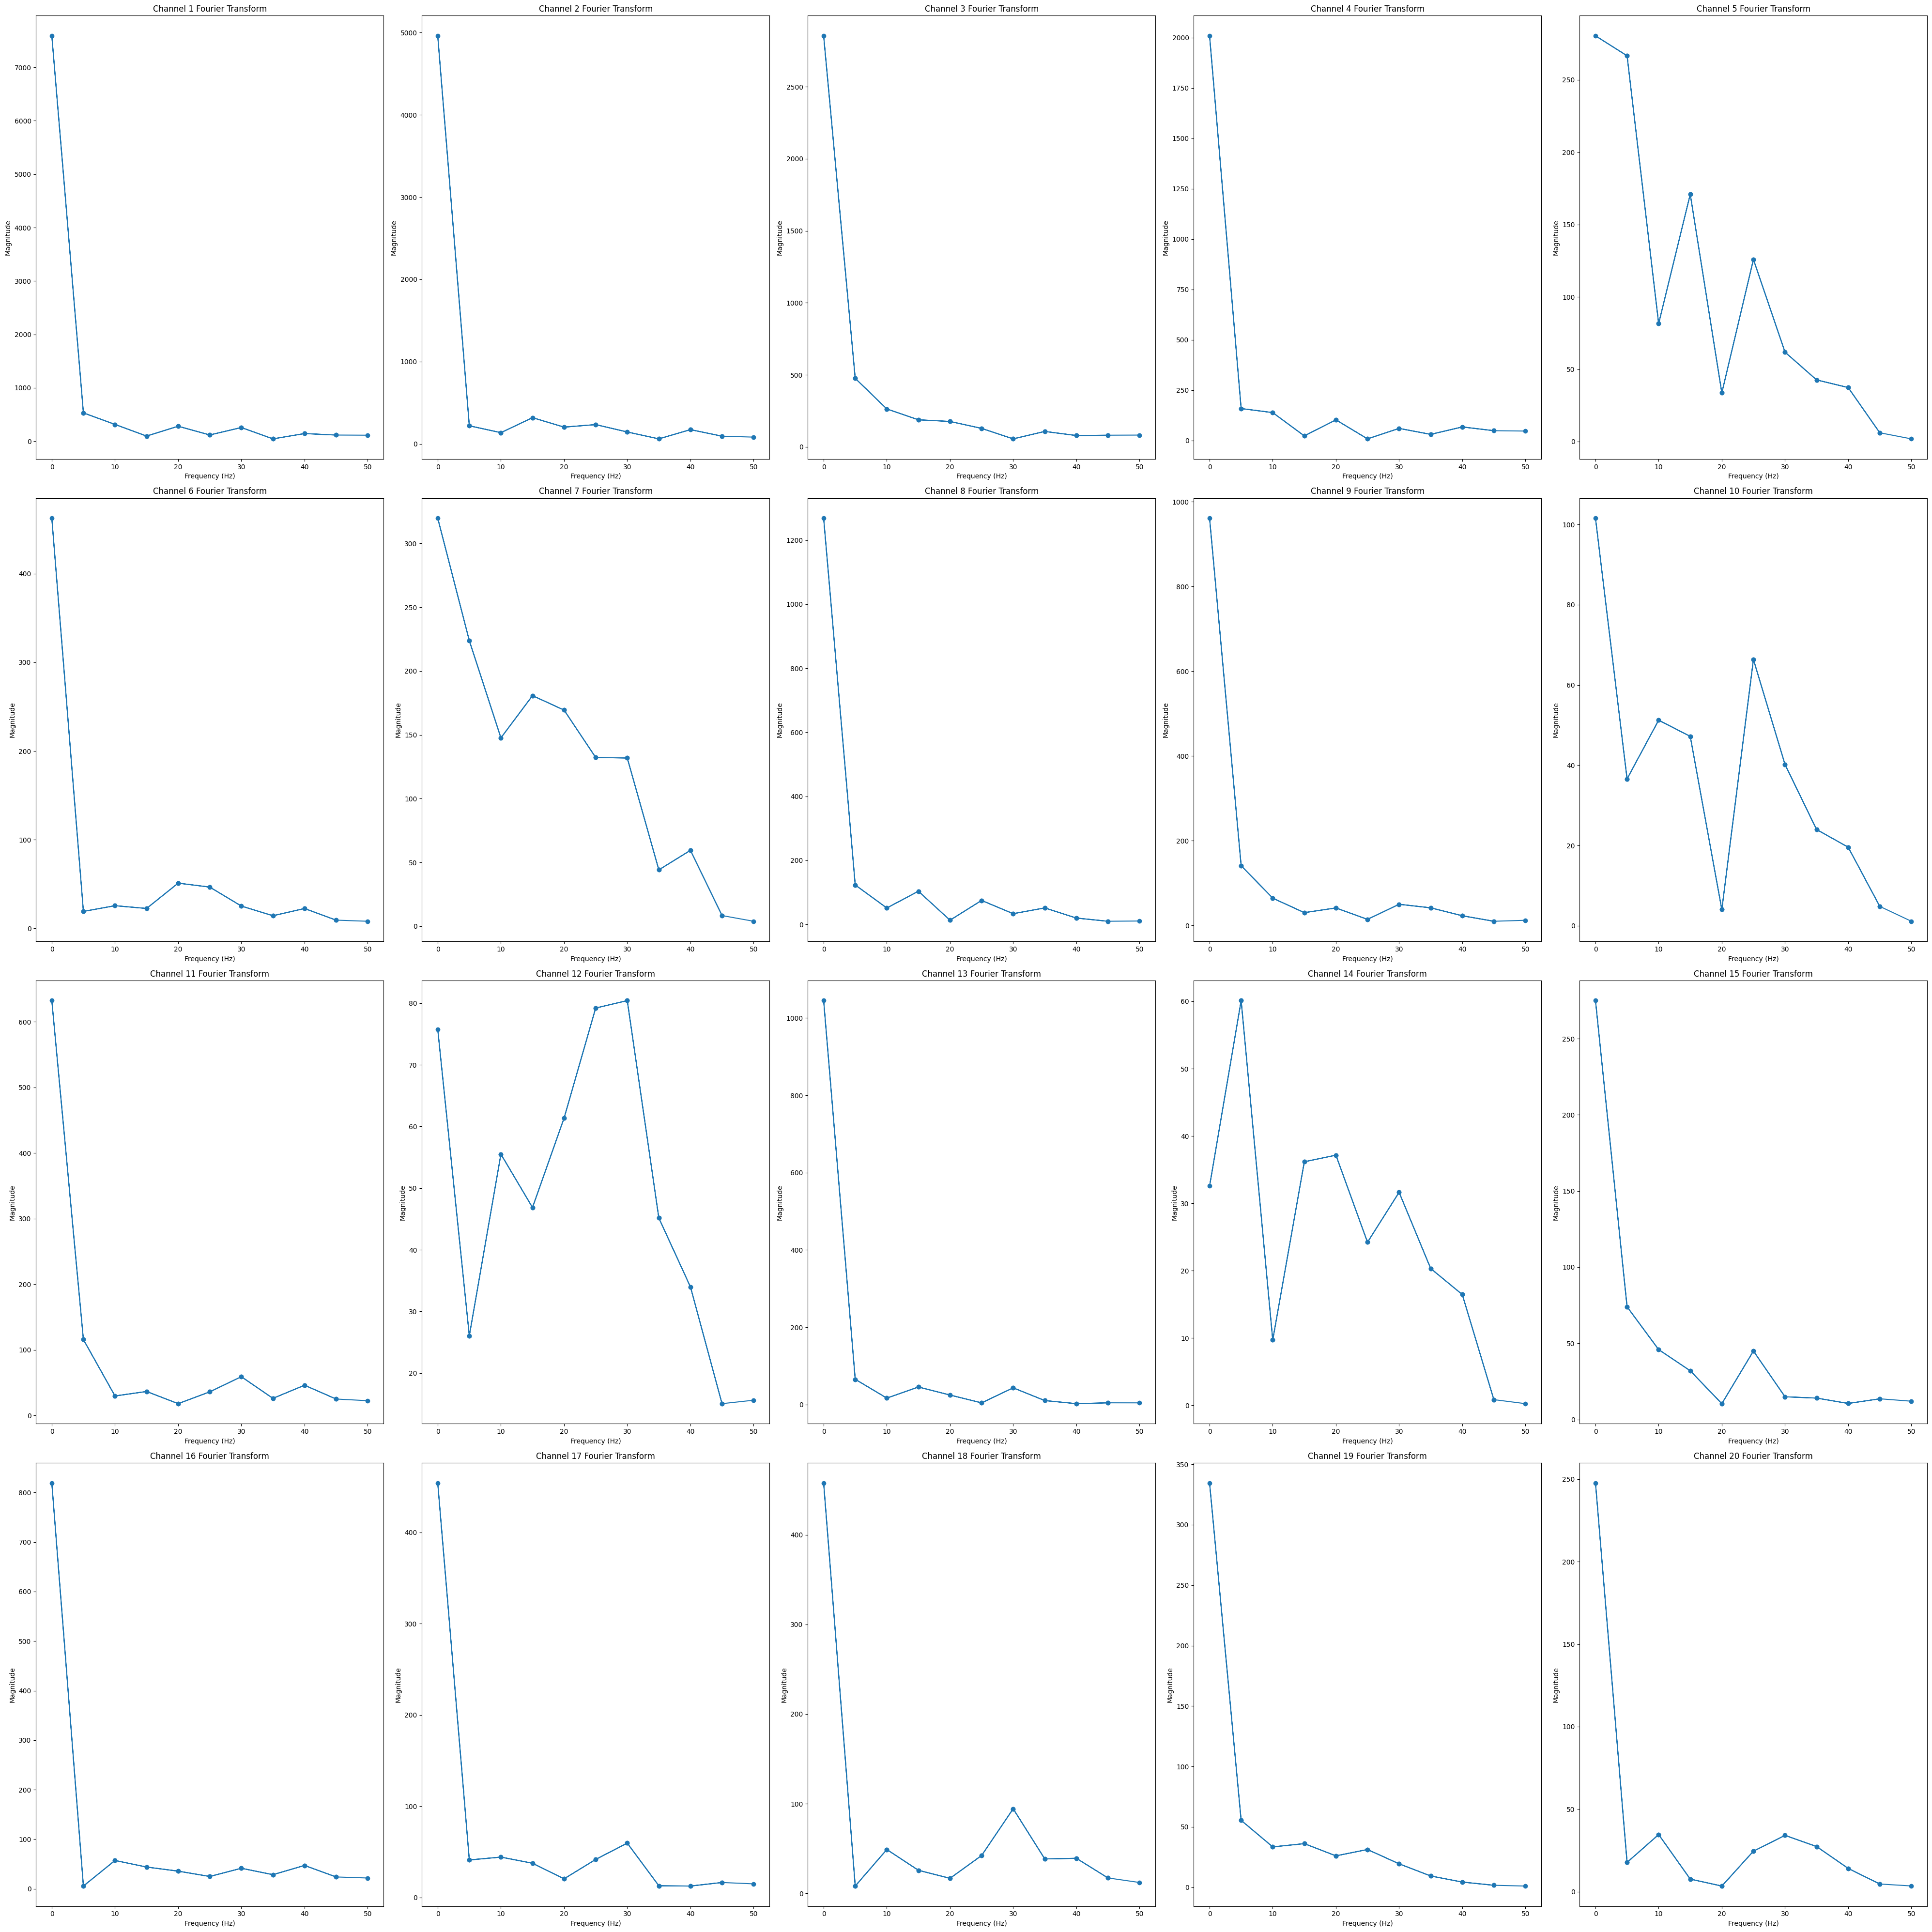

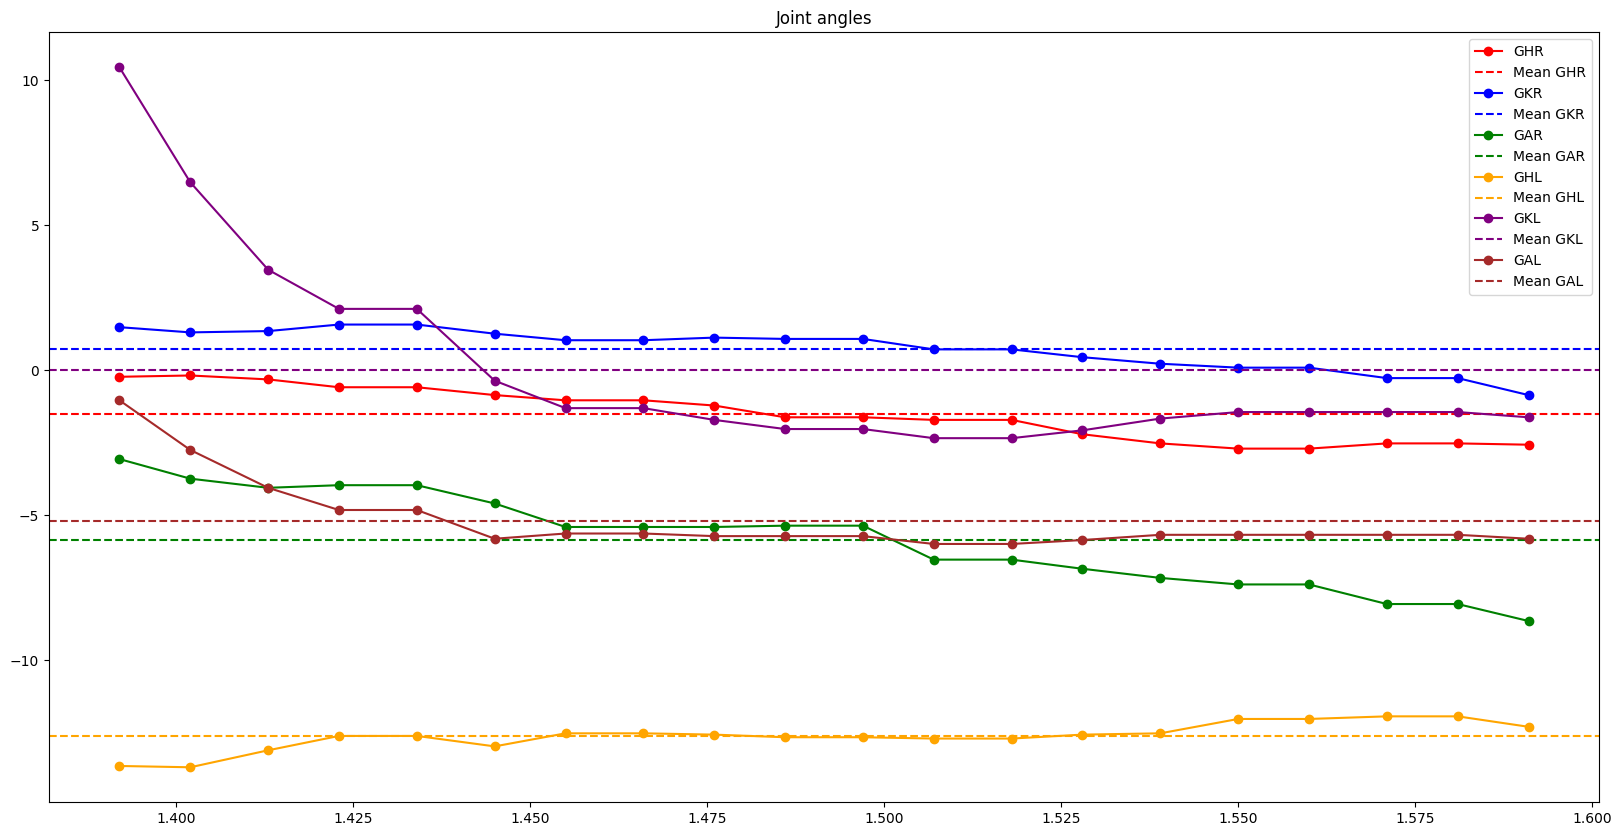

Window shape:  (20, 20)
Joint angle shape:  (20, 6)
Frequency shape:  (20,)
Magnitude shape:  (20, 20)
Frequency range:  0.0 50.0


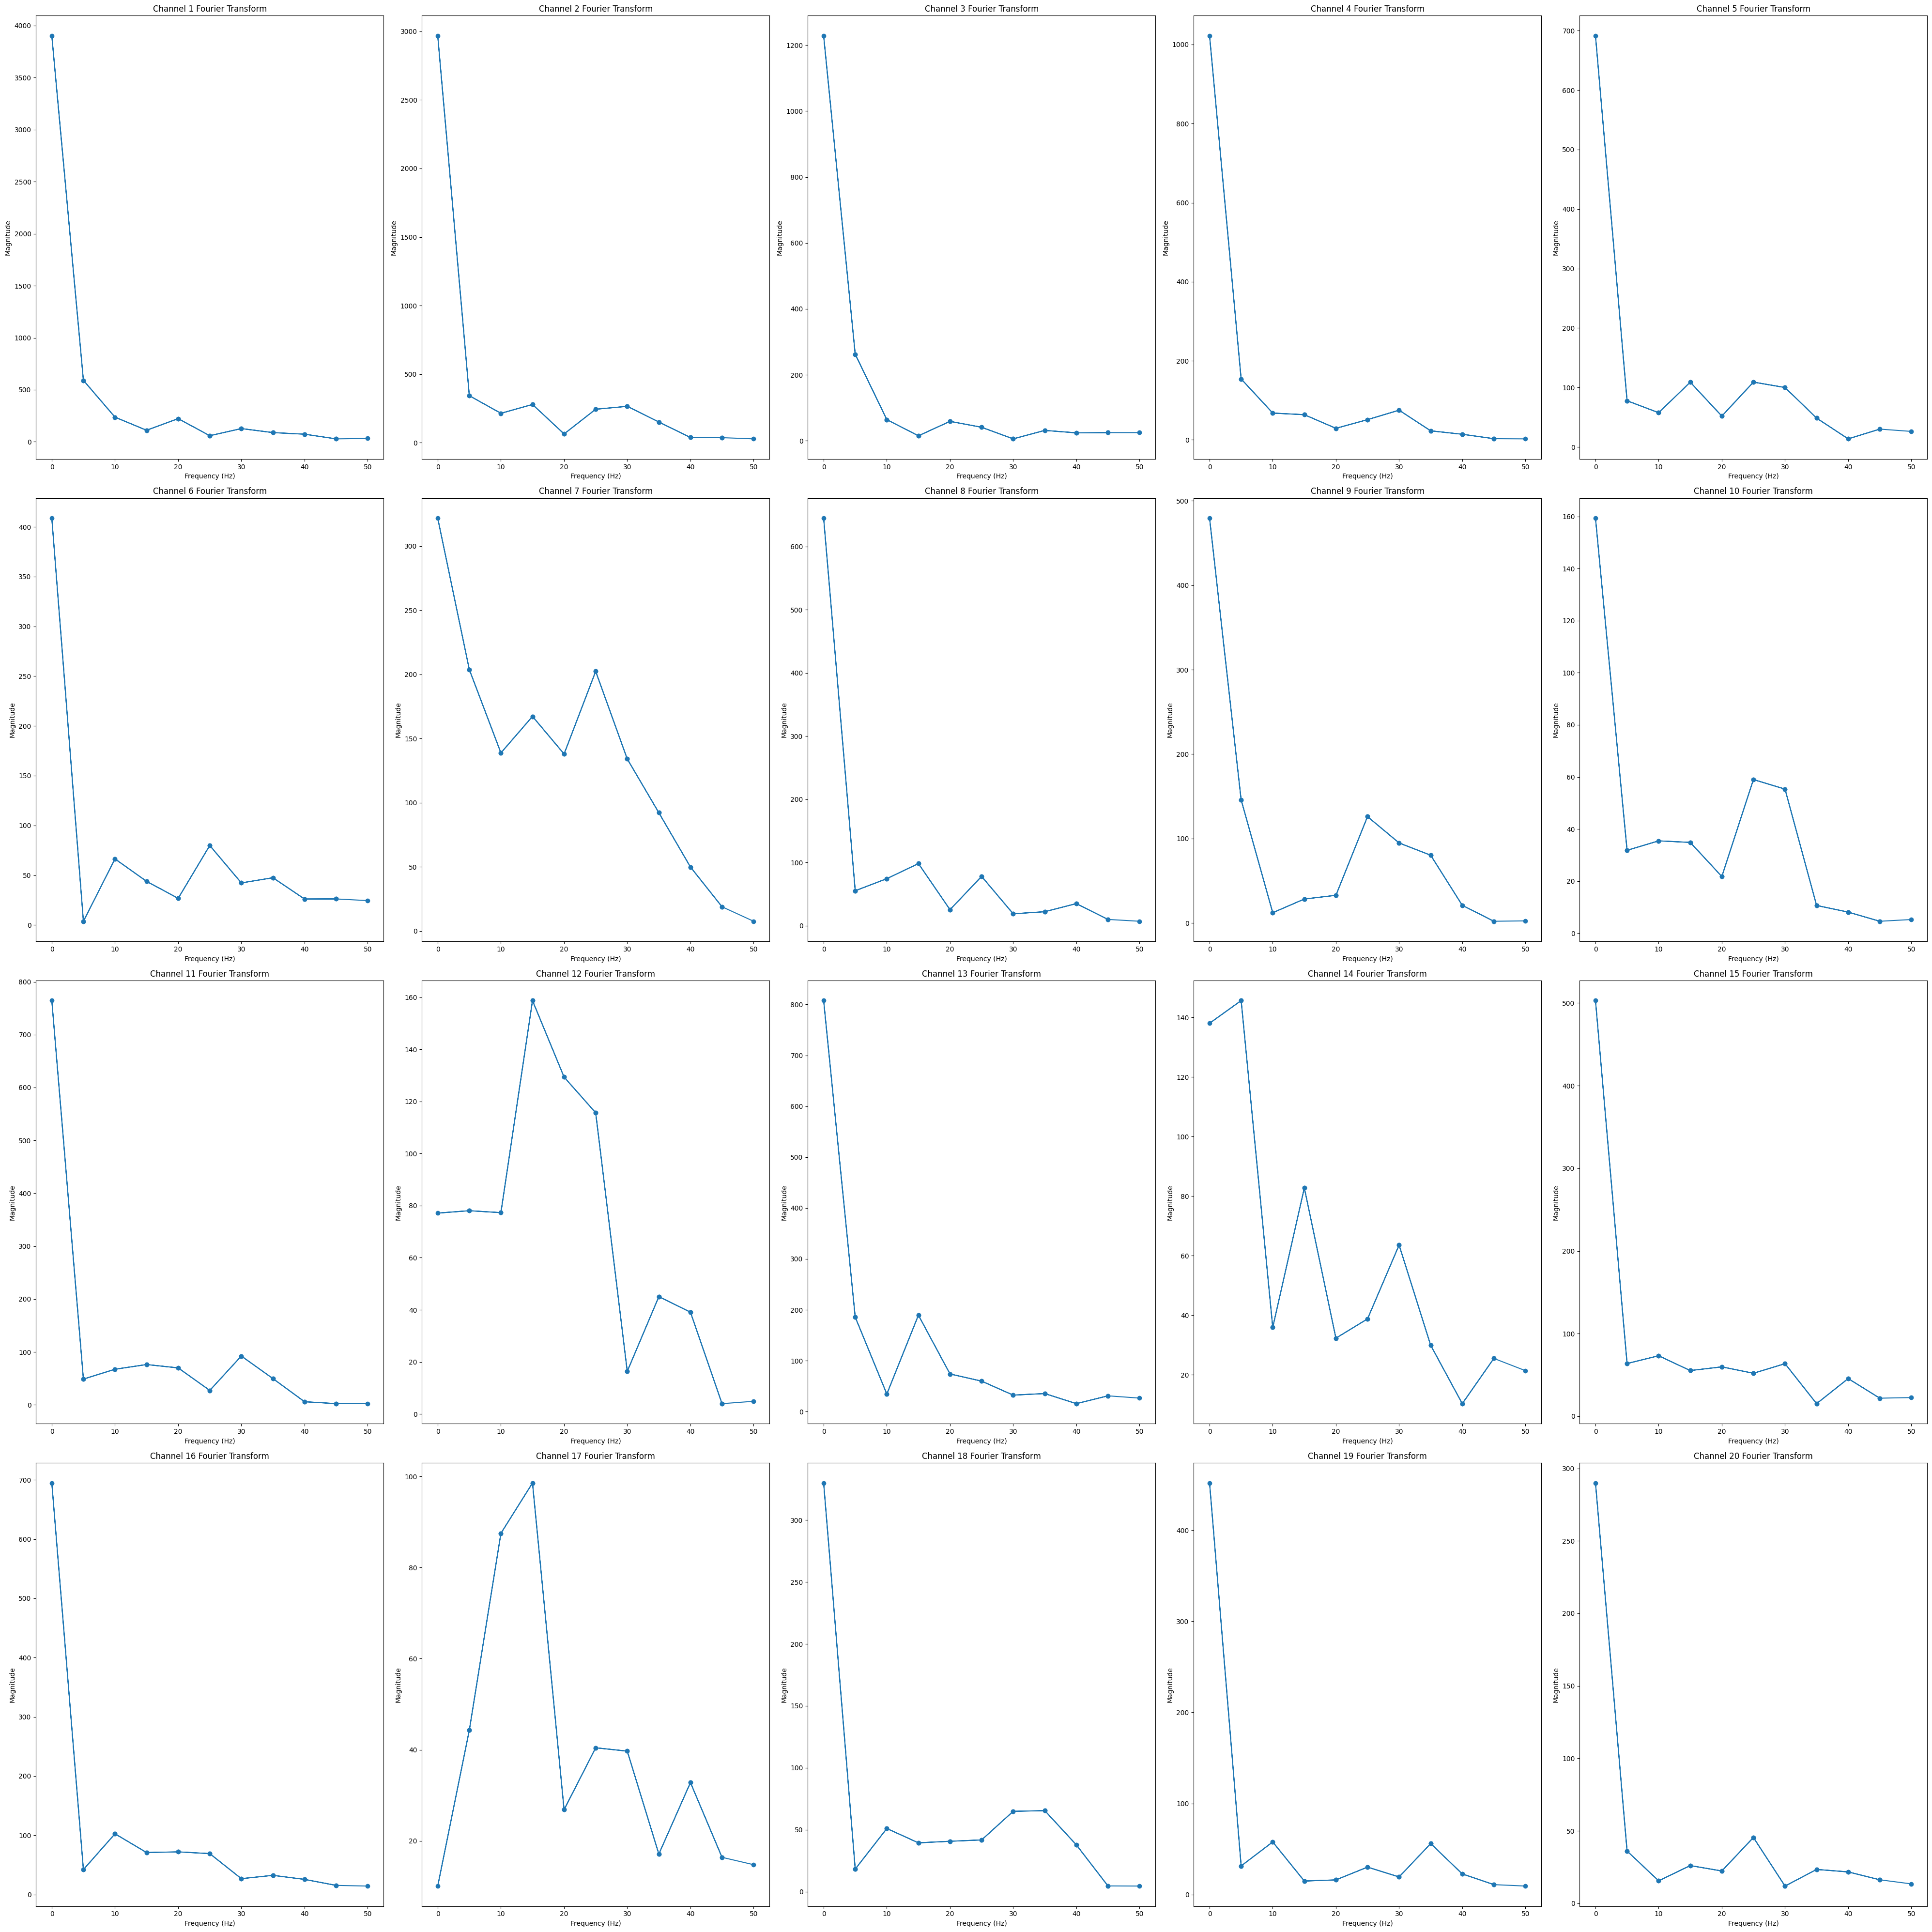

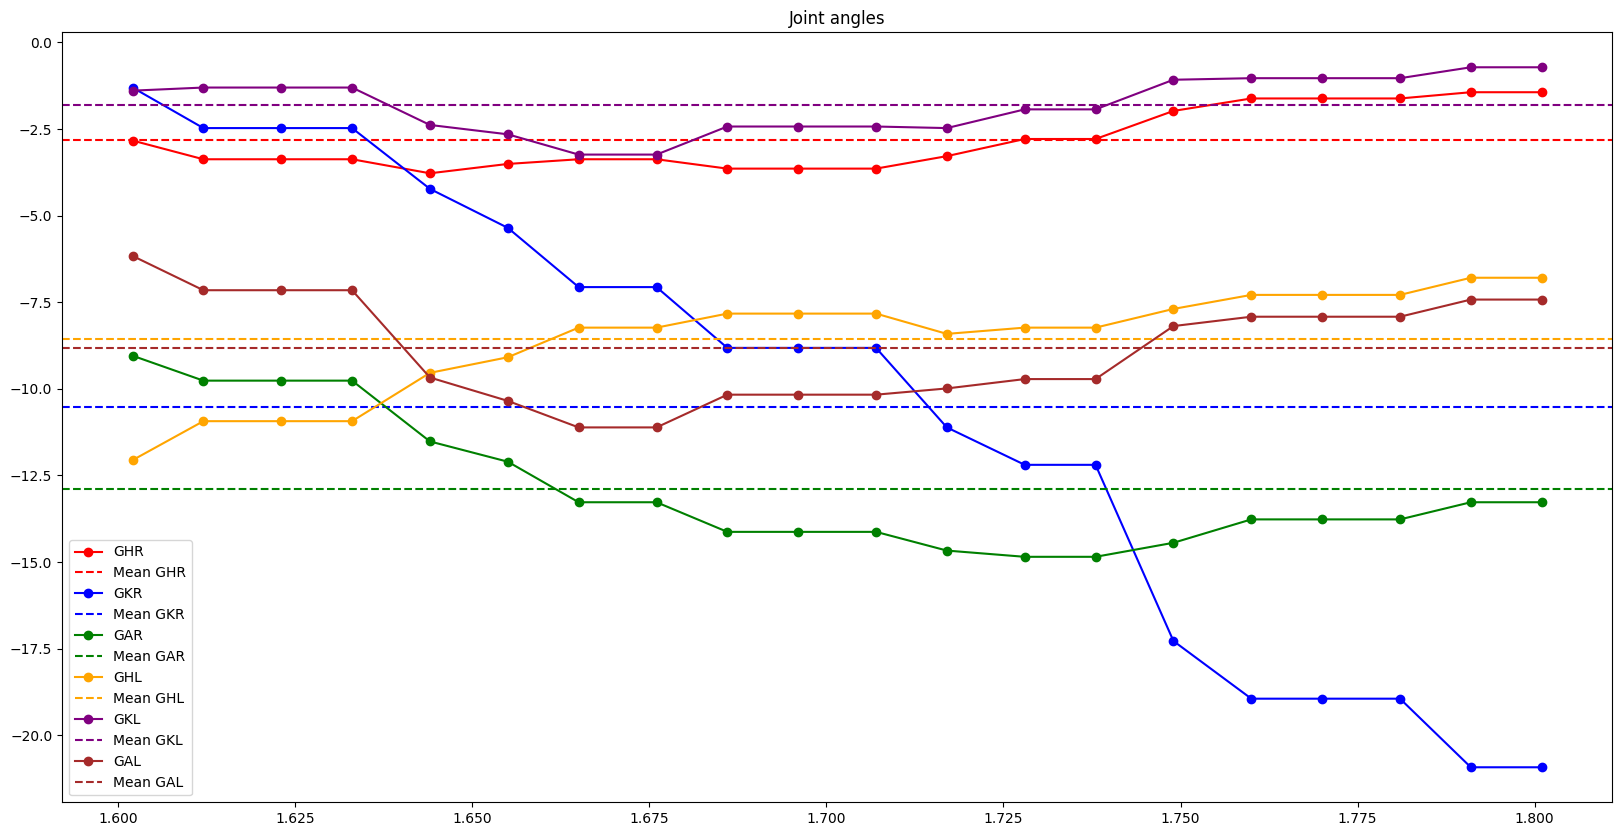

Window shape:  (20, 20)
Joint angle shape:  (20, 6)
Frequency shape:  (20,)
Magnitude shape:  (20, 20)
Frequency range:  0.0 50.0


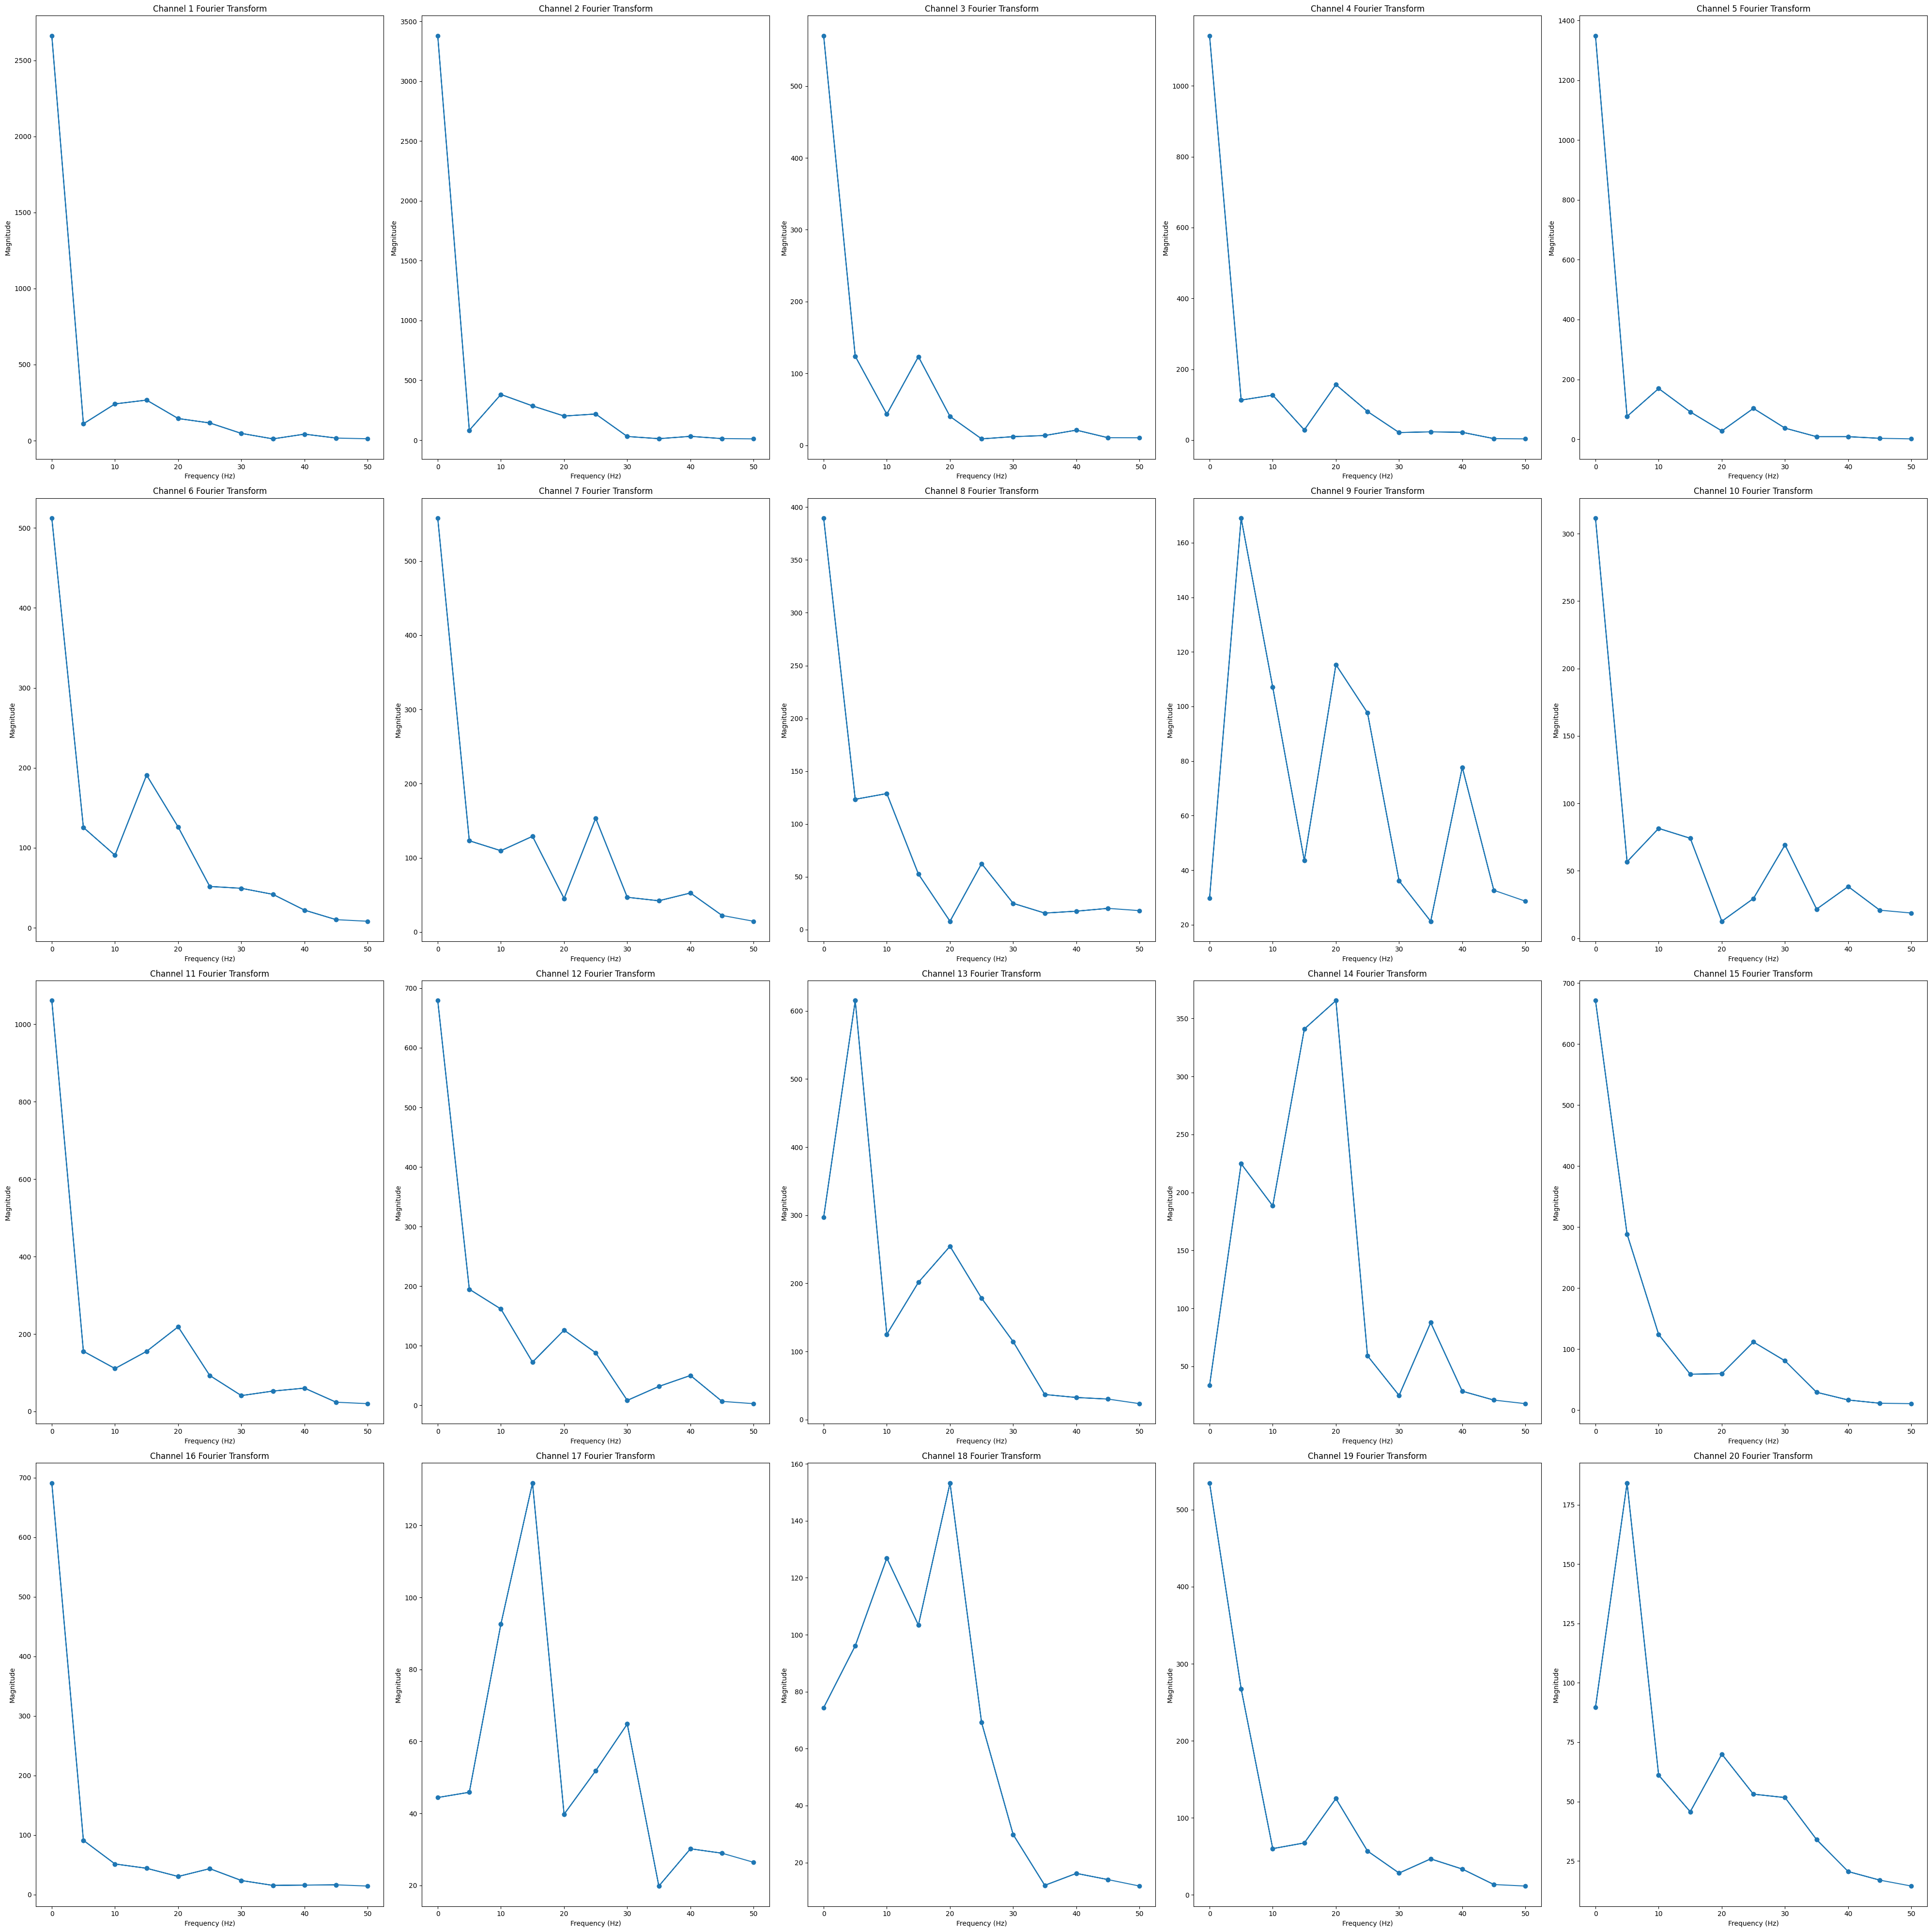

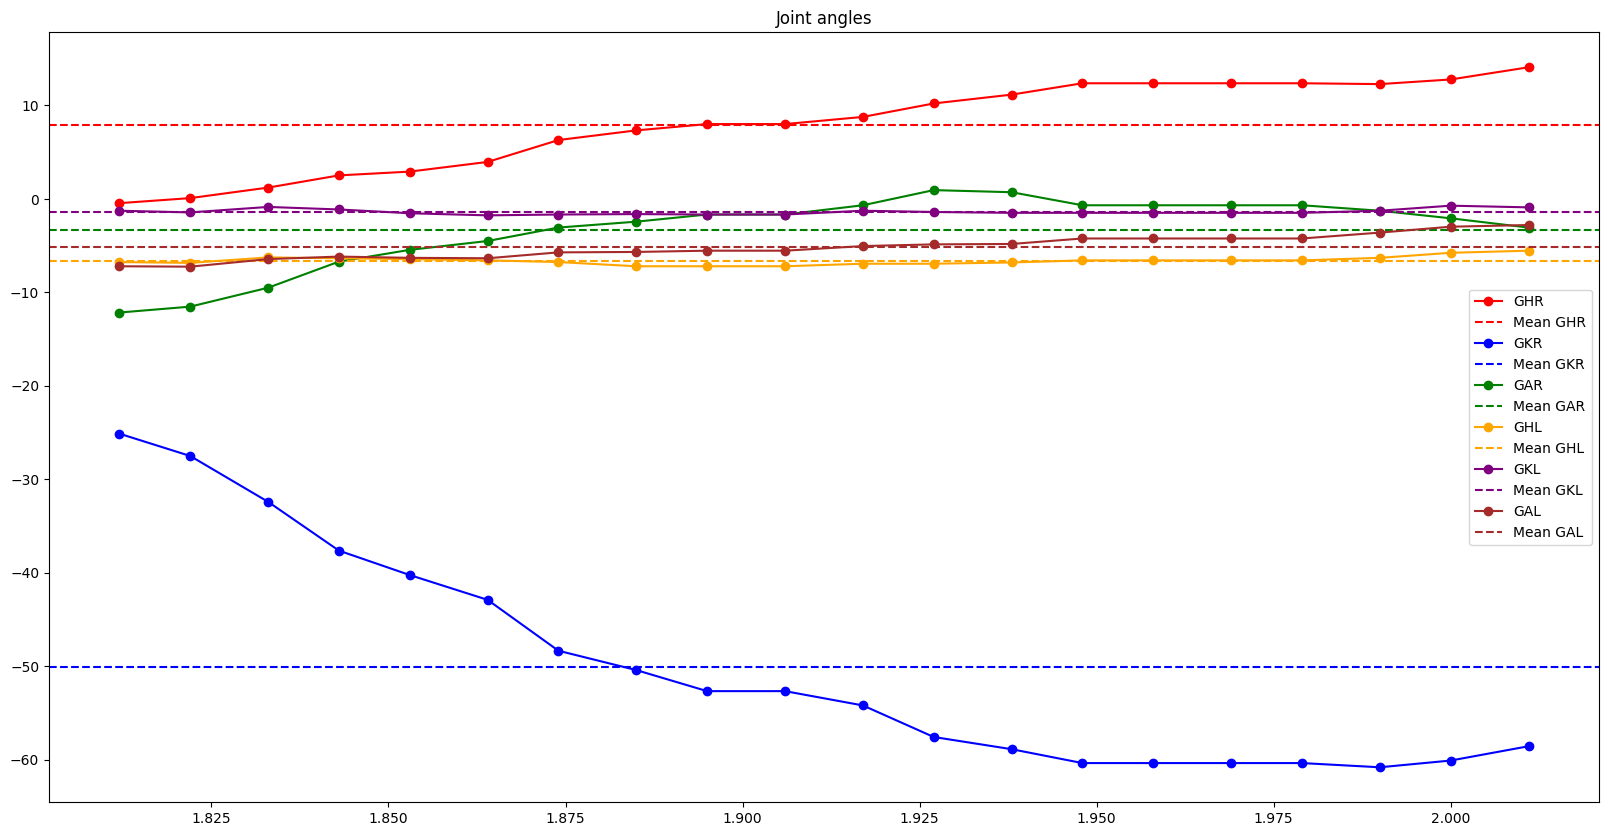

Window shape:  (20, 20)
Joint angle shape:  (20, 6)
Frequency shape:  (20,)
Magnitude shape:  (20, 20)
Frequency range:  0.0 50.0


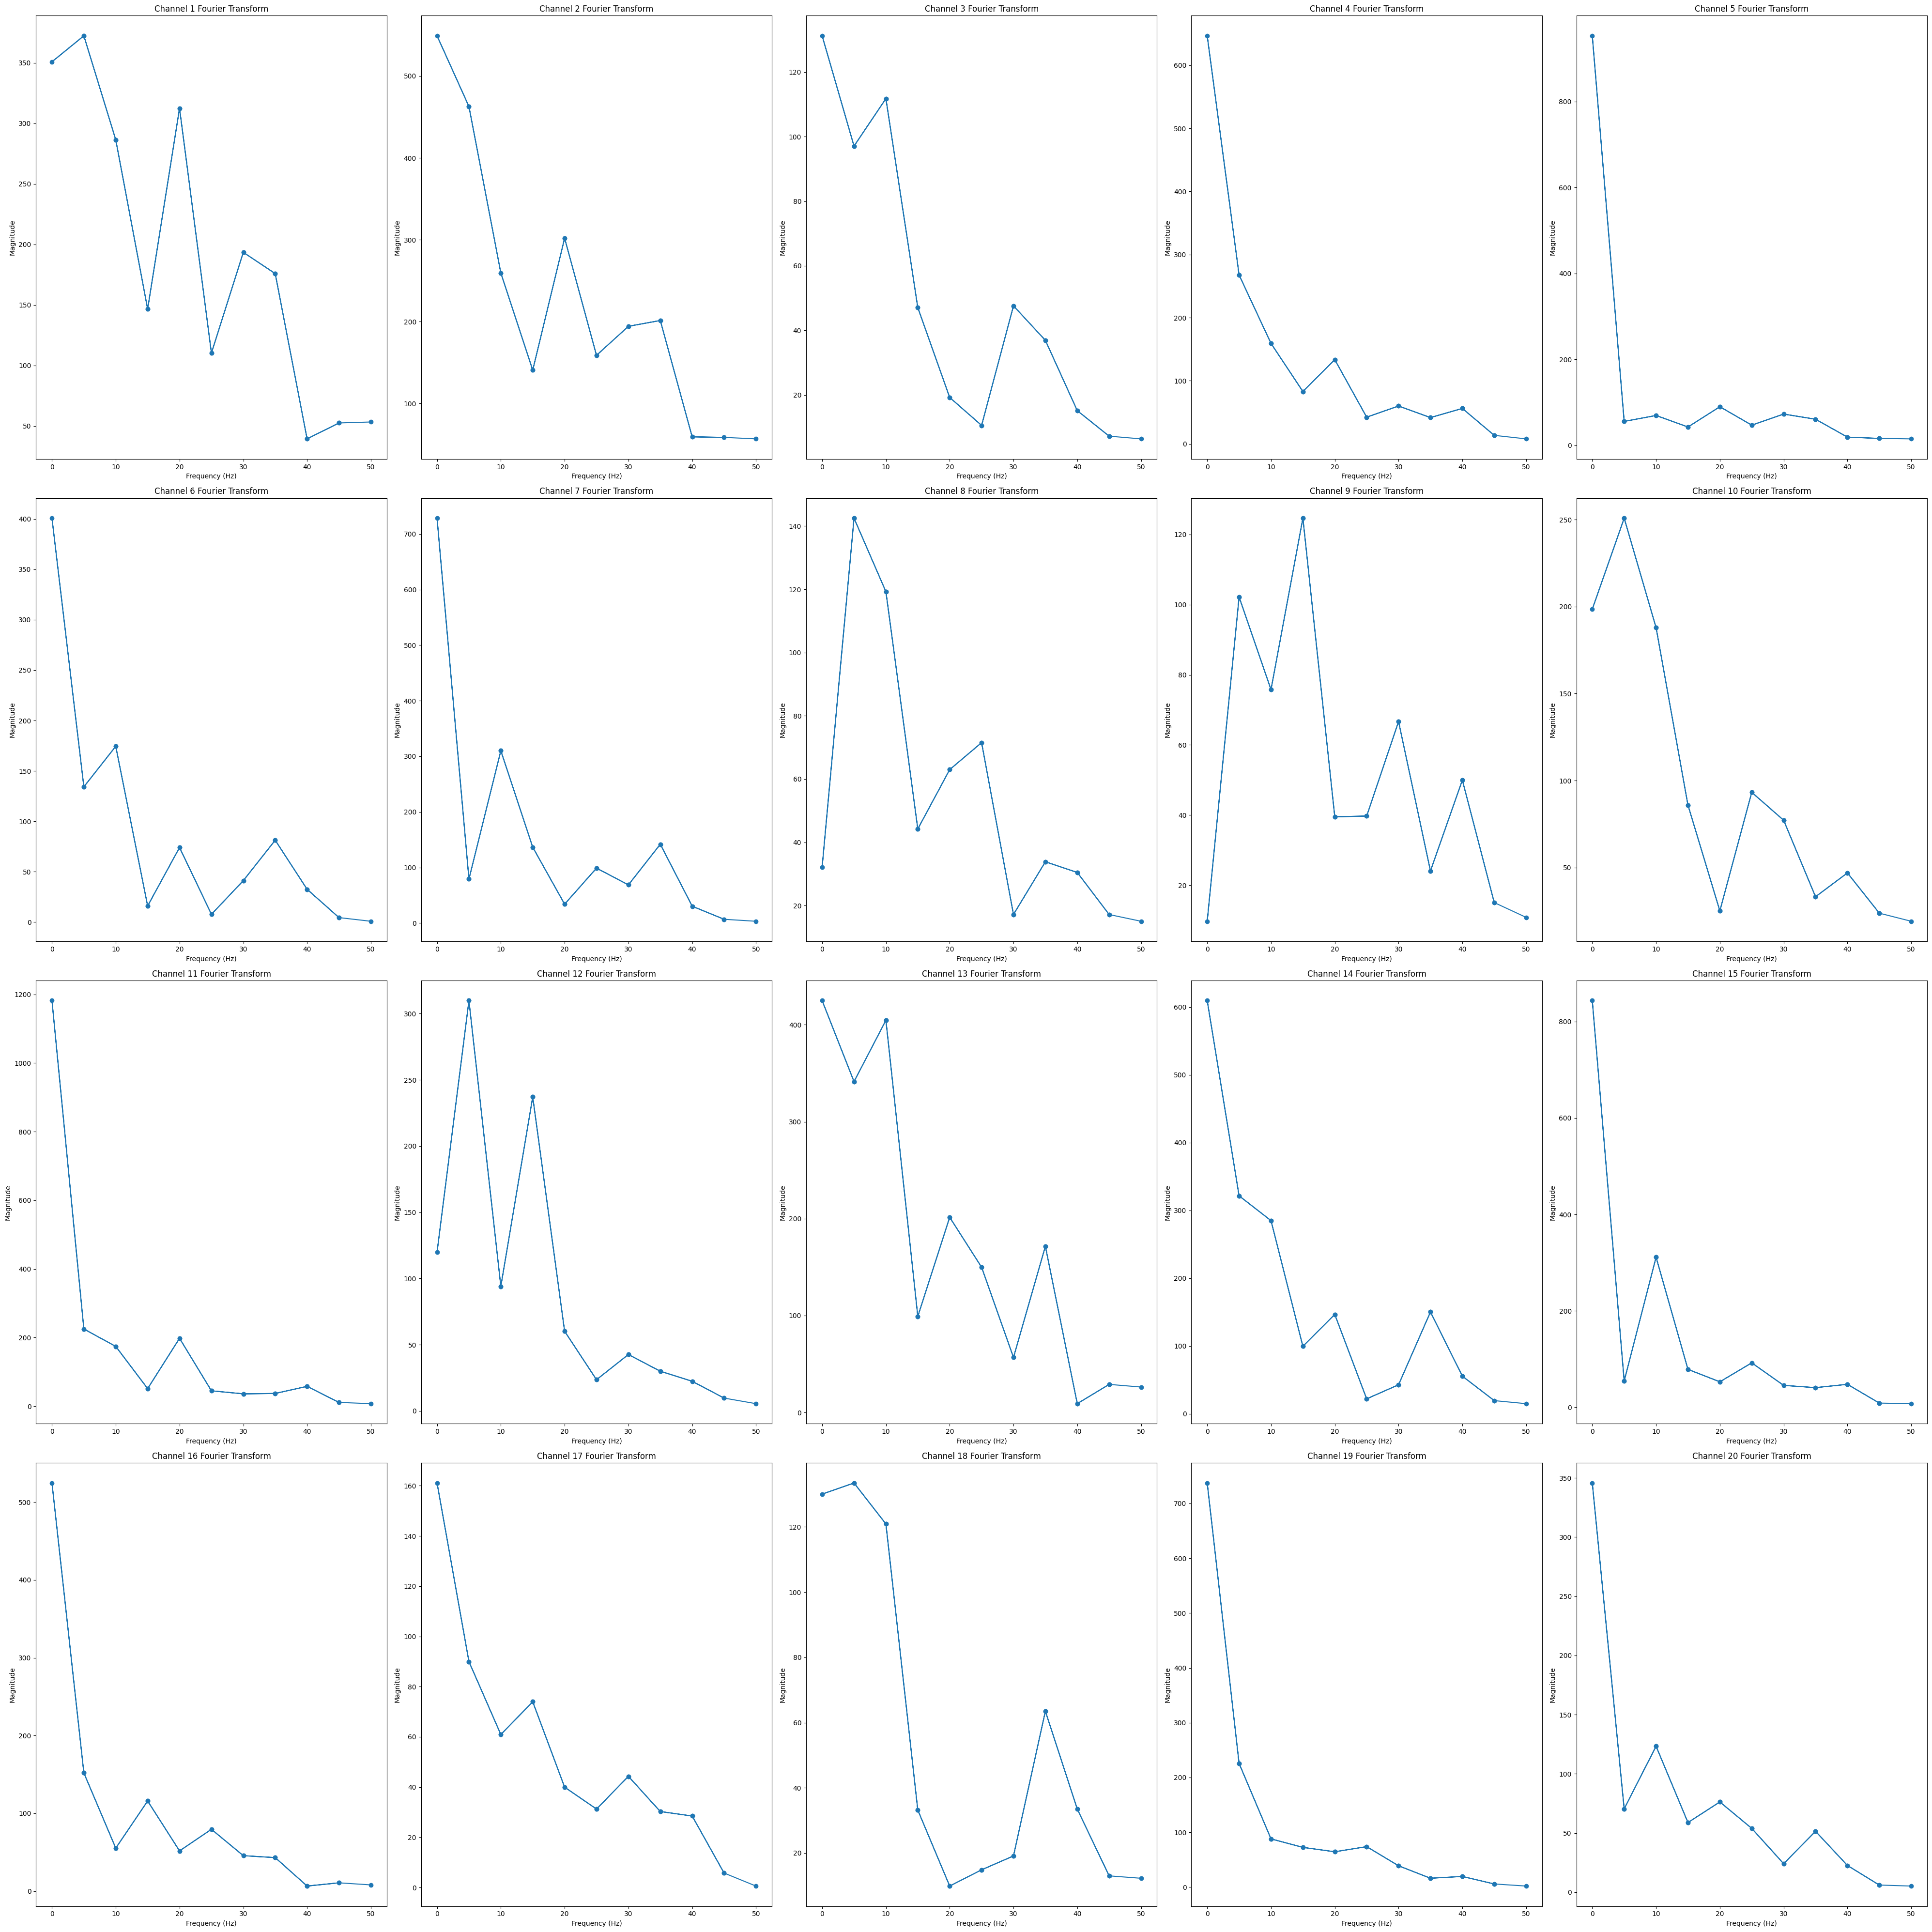

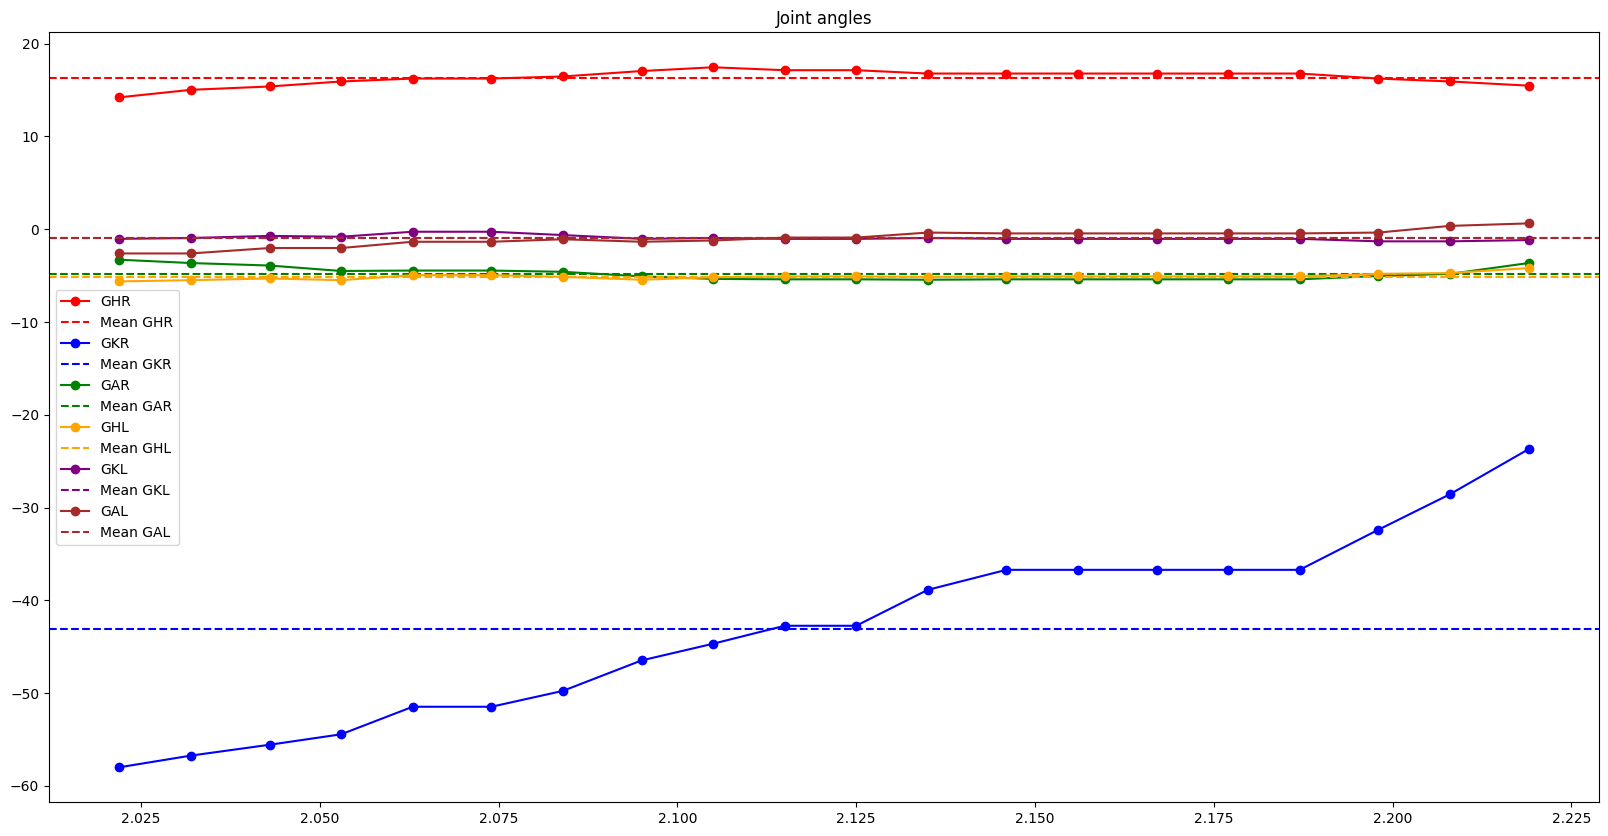

In [24]:
# in number of samples
window_size = 20
print("time shape", time.shape)

num_principle_components = 20
data = pca_transform(eeg, num_principle_components)

print("Number of windows in the data: ", data.shape[0] // window_size)

for count, i in enumerate(range(0, data.shape[0], window_size)):
    if count < 5:
        continue

    if count == 10:
        break

    window = data[i:i+window_size, :]
    window_time = time[i:i+window_size]
    window_joints = j_walk[i:i+window_size]
    

    print("Window shape: ", window.shape)
    print("Joint angle shape: ", window_joints.shape)

    f, y = fourier_transform(window, 100)

    print("Frequency shape: ", f.shape)
    print("Magnitude shape: ", y.shape)
    print("Frequency range: ", f.min(), f.max())

    fig, axs = plt.subplots(4, 5, figsize=(40, 40))
    for i in range(4):
        for j in range(5):  
            axs[i, j].plot(f, y[:, i*5+j], marker='o')
            axs[i, j].set_title(f'Channel {i*5+j+1} Fourier Transform')
            axs[i, j].set_xlabel('Frequency (Hz)')
            axs[i, j].set_ylabel('Magnitude')

    plt.tight_layout()
    plt.show()

    mean_joint_angle = np.mean(window_joints, axis=0)

    plt.figure(figsize=(20, 10))

    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink']
    for i in range(window_joints.shape[1]):
        plt.plot(window_time, window_joints[:, i], color=colors[i], label=joint_labels[i], marker='o')
        plt.axhline(mean_joint_angle[i], color=colors[i], linestyle='--', label=f'Mean {joint_labels[i]}')

    plt.legend()
    plt.title('Joint angles')
    plt.show()

In [25]:
channel_1 = eeg[:, 1]
print(channel_1[0:10])
# print(time[1000:1010].shape, channel_1[1000:1010].shape)
print(time[0:10])

# print('Time interval: ', t_int_data)

# graph the first channel vs time with walking highlighted


[ 28.82896434  85.49546008  86.7423597   64.38594555  81.54731953
  76.84518225  73.54294589  83.32525898  84.53581398 101.87464834]
0    0.139
1    0.142
2    0.153
3    0.163
4    0.174
5    0.184
6    0.194
7    0.205
8    0.215
9    0.226
Name: 0, dtype: float64


In [26]:
# # plot 64 channels in 8x8 grid, label the last 4 channels as EOG, and first 60 as EEG
# def visualize_subject_eeg(eeg, time):
#     fig, axs = plt.subplots(8, 8, figsize=(40, 40))
#     for i in range(8):
#         for j in range(8):
#             # print("mean:" + np.mean(eeg[:, i * 8 + j], axis=0))
#             # print("std:" + np.std(eeg[:, i * 8 + j], axis=0))
#             axs[i, j].plot(time, eeg[:, i * 8 + j])
#             if i == 7:
#                 axs[i, j].set_xlabel('Time (s)')
#             if j == 0:
#                 axs[i, j].set_ylabel('Voltage')
#             if i * 8 + j < 60:
#                 axs[i, j].set_title('EEG ' + str(i * 8 + j + 1))
#             else:
#                 axs[i, j].set_title('EOG ' + str(i * 8 + j + 1))
#     plt.tight_layout()
#     plt.show()

# visualize_subject_eeg(eeg, time)

In [27]:
def butter_lowpass(cutoff, fs, order=5):
    return sig.butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = sig.lfilter(b, a, data)
    return y

loop: 0
loop: 1
loop: 2
loop: 3
loop: 4


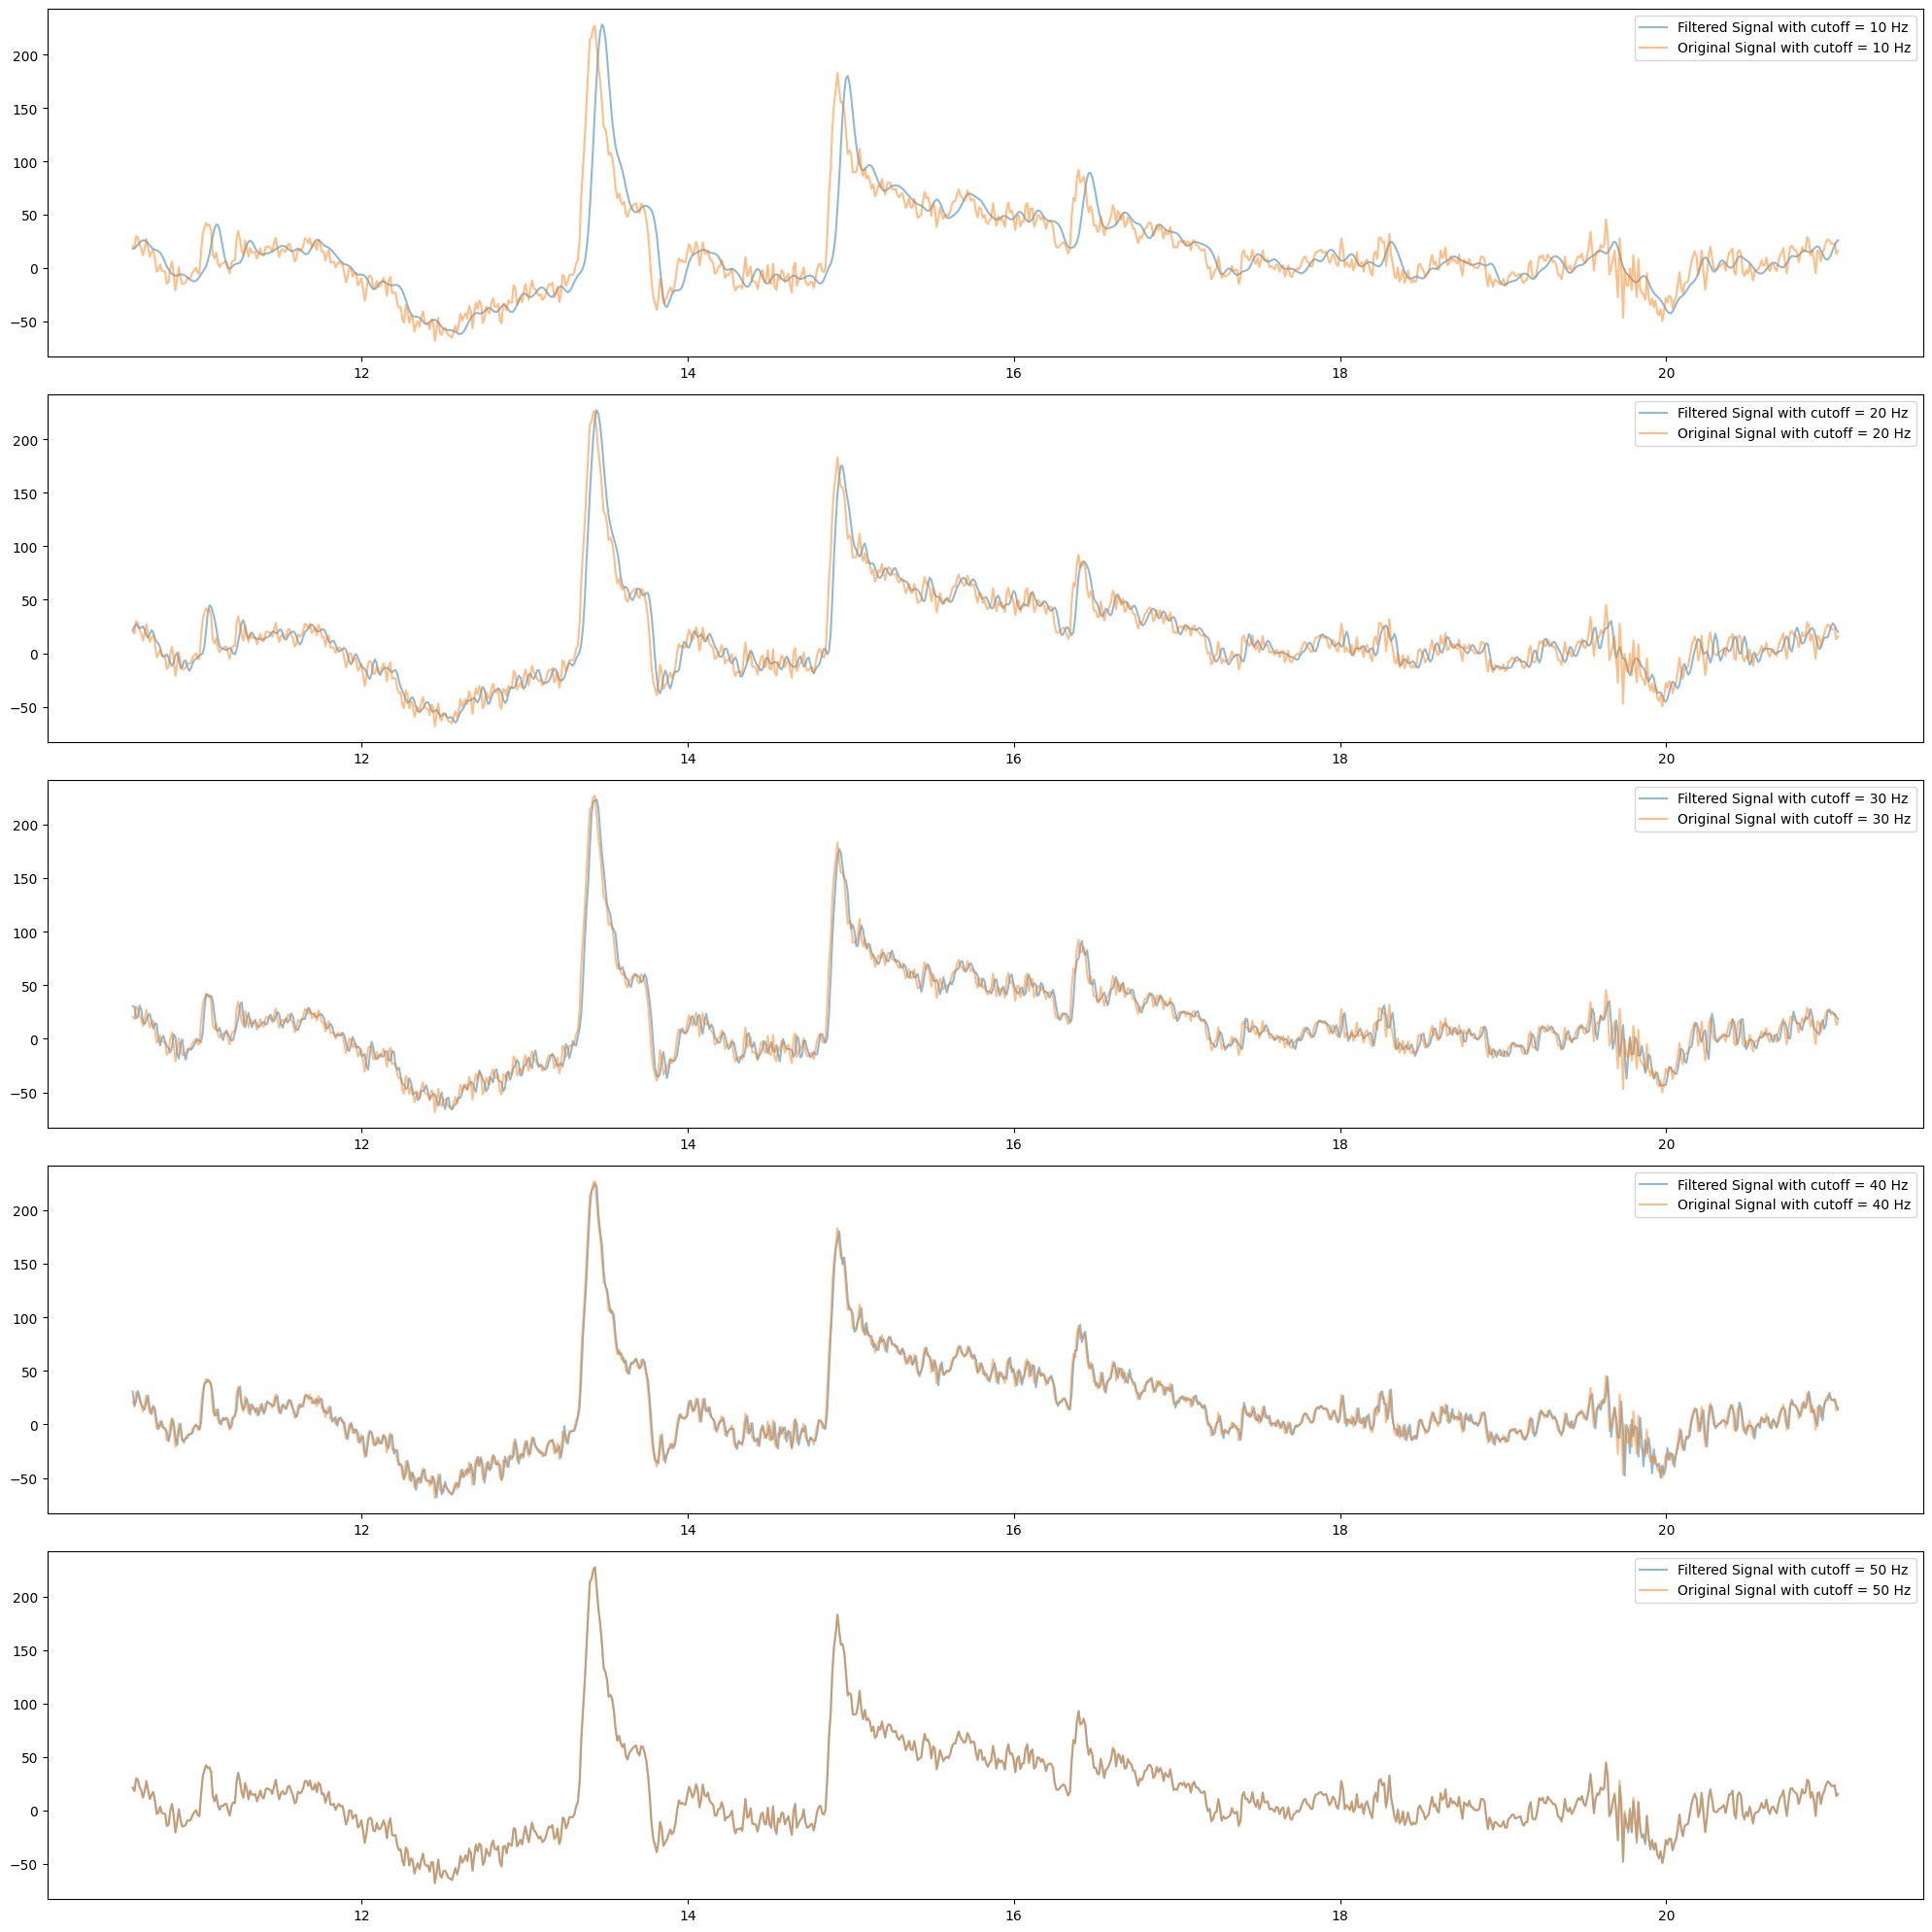

In [28]:
def lp(data, fc): # filter out all freq above 50 with 
    return butter_lowpass_filter(data=data, cutoff=fc, fs=100)

# y = lp(channel_1, 40)
figsize = (20, 20)

fig, axs = plt.subplots(5, 1, figsize=figsize)

for i in range (1, 6):
    index=i-1
    print(f"loop: {index}")
    y = eeg[:, 1]
    y_f = lp(y, i * 10) if i != 5 else lp(y, 49)
    axs[index].plot(time[1000:2000], y_f[1000:2000], alpha=.5, label=f"Filtered Signal with cutoff = {i*10} Hz")
    axs[index].plot(time[1000:2000], y[1000:2000], alpha=.5, label=f"Original Signal with cutoff = {i*10} Hz")
    axs[index].set_xlabel('Time (s)') if index == 5 else None
    axs[index].legend()

plt.tight_layout()
plt.show()

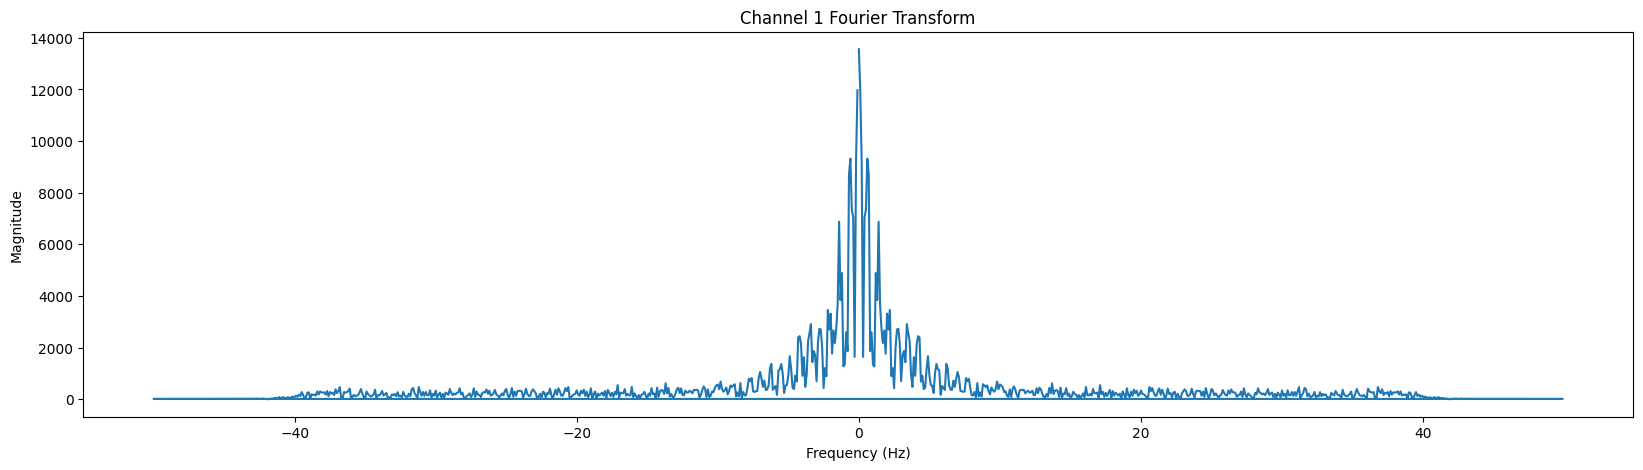

In [29]:
# use fourier transform to get the signal in frequency domain
def fourier_transform(data, fs):
    n = len(data)
    f = np.fft.fftfreq(n, 1/fs)
    y = np.fft.fft(data)
    return f, y

channel_1 = eeg[:, 1]

# filter the signal
channel_1_f = lp(channel_1, 40)
# get the fourier transform
f, y = fourier_transform(channel_1_f[1000:2000], 100)

plt.figure(figsize=(20, 5))
plt.plot(f, np.abs(y))
plt.title('Channel 1 Fourier Transform')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.show()

In [32]:
def visualize_subject_eeg_flt(eeg, time):
    print("test")
    eeg_f = lp_50(eeg)
    fig, axs = plt.subplots(8, 8, figsize=(40, 40))
    print(time.shape)
    print(egg_f.shape)
    for i in range(8):
        for j in range(8):
            # axs[i, j].plot(time, eeg[:, i * 8 + j], label="o", alpha=.3)
            
            print(eeg_f[:, i * 8 + j].shape)
            axs[i, j].plot(time, eeg_f[:, i * 8 + j], label="f", alpha=.3)
            if i == 7:
                axs[i, j].set_xlabel('Time (s)')
            if j == 0:
                axs[i, j].set_ylabel('Voltage')
            if i * 8 + j < 60:
                axs[i, j].set_title('EEG ' + str(i * 8 + j + 1))
            else:
                axs[i, j].set_title('EOG ' + str(i * 8 + j + 1))
    plt.tight_layout()
    plt.legend()
    plt.show()

print("test")
print("time shape: " + str(time[:].shape))
print("eeg shape: " + str(eeg[:].shape))
visualize_subject_eeg(eeg, time)

test
time shape: (137242,)
eeg shape: (90000, 64)


NameError: name 'visualize_subject_eeg' is not defined